# Approche suppervisée 

#### Rappel du contexte : 
On souhaite catégoriser les questions issues de Stackoverflow.

Nous avons précédemment effectué les étapes de pré-traitement (nettoyage des textes, tokenisation, suppression de stop words et lemmatisation)

Dans ce notebook, nous allons tester des  algorithme de classification supervisée pour prédire les tags.
Nous testerons: 
   - MultiOutputClassifier avec regression logistique
   - Random Forest
   - Réseau de neurones simple :
       - 1 couche cachée (dimensions raisonnables) + couche de sortie (sigmoid)
       - HP: learning rate (+ dropout? si nécessaire)
       -  Loss :  CategoricalCrossentropy (one-hot) / SparseCategoricalCrossentropy (int)


Nous utilisons des méthodes de vectorisation et word embeddings:
   - Tf-IDF
   - Doc2Vec (gensim)
   - BERT
   - USE 

Pour évaluer la classification, nous utilisons: 
   - Score de Jaccard.
   - F1-score.
   - Précision
   - Hamming_loss
   - Matrice de confusion 
   - Classification report 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier


from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import *
from sklearn.pipeline import Pipeline


import time
import mlflow

from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn import utils



import warnings
warnings.filterwarnings("ignore")

# Préparation

In [2]:
df = pd.read_csv("data_last_version")
df.shape

(37435, 17)

In [3]:
df.head(5)

,Title,Body,Tags,Score,ViewCount,AnswerCount,CreationDate,Corpus,Extracted_code,New_Tags,Nb_Tags,Title_tokens,Body_tokens,Corpus_tokens,Title_tokens_str,Body_tokens_str,Corpus_tokens_str
0,keycloak authentication problems when using do...,so i have a spring boot application i also us...,"['java', 'spring', 'spring-boot', 'docker', 'k...",3,4805,1,2020-01-07 12:09:05,keycloak authentication problems when using do...,[' keycloak:\n image: jboss/keycloak\n ...,"['java', 'spring', 'spring-boot', 'docker']",4,"['keycloak', 'authentication', 'problem', 'usi...","['spring', 'boot', 'application', 'also', 'use...","['keycloak', 'authentication', 'problem', 'usi...",keycloak authentication problem using docker j...,spring boot application also use swagger testi...,keycloak authentication problem using docker j...
1,why doesn t the pod dependency manager detect ...,so this question is a follow up to my previo...,"['javascript', 'reactjs', 'react-native', 'mod...",6,2483,2,2020-01-13 22:20:14,why doesn t the pod dependency manager detect ...,['yarn add @react-native-community/masked-view...,"['javascript', 'reactjs', 'react-native']",3,"['pod', 'dependency', 'manager', 'detect', 'ne...","['question', 'follow', 'previous', 'question',...","['pod', 'dependency', 'manager', 'detect', 'ne...",pod dependency manager detect necessary module...,question follow previous question different ap...,pod dependency manager detect necessary module...
2,how to add an unique constraint ignoring spec...,how to add an unique constraint ignoring spec...,"['sql', 'regex', 'postgresql', 'unique-constra...",2,1396,2,2020-01-13 22:23:55,how to add an unique constraint ignoring spec...,['CREATE TABLE my_table(\n SomeTextColumn c...,"['sql', 'regex', 'postgresql']",3,"['add', 'unique', 'constraint', 'ignoring', 's...","['add', 'unique', 'constraint', 'ignoring', 's...","['add', 'unique', 'constraint', 'ignoring', 's...",add unique constraint ignoring special charact...,add unique constraint ignoring special charact...,add unique constraint ignoring special charact...
3,is there a way to connect a java desktop app w...,i ve been developing a java desktop app from s...,"['java', 'mysql', 'database', 'servlets', 'des...",2,669,3,2020-01-13 22:43:07,is there a way to connect a java desktop app w...,[],"['java', 'mysql', 'database']",3,"['way', 'connect', 'java', 'desktop', 'app', '...","['developing', 'java', 'desktop', 'app', 'time...","['way', 'connect', 'java', 'desktop', 'app', '...",way connect java desktop app mysql servlets so...,developing java desktop app time basically cru...,way connect java desktop app mysql servlets so...
4,exclude an enum property of a model from using...,i am developing the aspdotnet core application...,"['c#', 'json', 'asp.net-core', '.net-core', 's...",6,3339,1,2020-01-20 18:19:47,exclude an enum property of a model from using...,['public void ConfigureServices(IServiceCollec...,"['c#', 'json', 'asp.net-core', '.net-core']",4,"['exclude', 'enum', 'property', 'model', 'usin...","['developing', 'aspdotnet', 'core', 'applicati...","['exclude', 'enum', 'property', 'model', 'usin...",exclude enum property model using jsonstringen...,developing aspdotnet core application using la...,exclude enum property model using jsonstringen...


In [4]:
data_corpus = df["Corpus_tokens"] # utilisé avec TF-IDF
data_corpus_str = df["Corpus_tokens_str"] # utilisé avec Doc2Vec - BERT - USE

### Encodage des tags : MultiLabelBinarizer

In [5]:
df['New_Tags'].explode().nunique()

8583

In [6]:
df_2 = df.copy()

In [7]:
# Supprimer les crochets des valeurs de la colonne "Tags"
df_2['New_Tags']=df_2['New_Tags'].str.replace("[", '')
df_2['New_Tags']=df_2['New_Tags'].str.replace("]", '')
df_2['New_Tags']=df_2['New_Tags'].str.replace("'", '')
df_2.New_Tags

0        java, spring, spring-boot, docker
1        javascript, reactjs, react-native
2                   sql, regex, postgresql
3                    java, mysql, database
4        c#, json, asp.net-core, .net-core
                       ...                
37430          spring, spring-boot, kotlin
37431           c++, linux, multithreading
37432             python, bash, tensorflow
37433                python, pandas, regex
37434         reactjs, typescript, next.js
Name: New_Tags, Length: 37435, dtype: object

In [8]:
df_2.New_Tags.nunique()

8583

In [9]:
# Convertir les valeurs de la colonne "Tags" en listes
df_2['New_Tags'] = df_2['New_Tags'].apply(lambda x: x.split(','))
# Supprimer les espaces au début et à la fin de chaque tag
df_2['New_Tags'] = df_2['New_Tags'].apply(lambda tags: [tag.strip() for tag in tags] if isinstance(tags, list) else tags)
df_2.New_Tags

0        [java, spring, spring-boot, docker]
1        [javascript, reactjs, react-native]
2                   [sql, regex, postgresql]
3                    [java, mysql, database]
4        [c#, json, asp.net-core, .net-core]
                        ...                 
37430          [spring, spring-boot, kotlin]
37431           [c++, linux, multithreading]
37432             [python, bash, tensorflow]
37433                [python, pandas, regex]
37434         [reactjs, typescript, next.js]
Name: New_Tags, Length: 37435, dtype: object

In [10]:
# Vérification du nombre de tags uniques
df_2.New_Tags.explode().nunique()

100

In [11]:
df_select = df_2.copy()
df_select.shape

(37435, 17)

In [12]:
tags_df = df_select["New_Tags"]

# Initialiser et appliquer MultiLabelBinarizer
mlb = MultiLabelBinarizer()
selected_tags = mlb.fit_transform(tags_df)
selected_tags.shape

(37435, 100)

In [13]:
print(len(mlb.classes_))
print(mlb.classes_)

100
['.net' '.net-core' 'algorithm' 'amazon-s3' 'amazon-web-services'
 'android' 'android-studio' 'angular' 'apache-spark' 'api' 'arrays'
 'asp.net' 'asp.net-core' 'assembly' 'asynchronous' 'authentication'
 'aws-lambda' 'azure' 'bash' 'c' 'c#' 'c++' 'css' 'dart' 'database'
 'dataframe' 'deep-learning' 'django' 'docker' 'docker-compose' 'express'
 'firebase' 'flutter' 'function' 'git' 'google-chrome'
 'google-cloud-firestore' 'google-cloud-platform' 'gradle' 'html' 'image'
 'ios' 'java' 'javascript' 'jestjs' 'jquery' 'json' 'keras' 'kotlin'
 'kubernetes' 'laravel' 'linux' 'list' 'loops' 'machine-learning' 'macos'
 'matplotlib' 'maven' 'mongodb' 'multithreading' 'mysql' 'next.js'
 'node.js' 'npm' 'numpy' 'opencv' 'pandas' 'performance' 'php'
 'postgresql' 'pyspark' 'python' 'python-3.x' 'pytorch' 'r' 'react-hooks'
 'react-native' 'reactjs' 'regex' 'selenium' 'spring' 'spring-boot' 'sql'
 'sql-server' 'string' 'swift' 'swiftui' 'templates' 'tensorflow'
 'testing' 'typescript' 'unit-testi

In [14]:
selected_tags

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [19]:
# tags_column = data[['New_Tags']]
# tags_column.to_csv("tags.csv", index=False)

In [22]:
# a = np.array(encoded_tags)
# np.savetxt('tags_encoded.txt', a, fmt='%i')

In [15]:
def model_scores(model, y_true, y_pred):
    
    jaccard_micro= jaccard_score(y_true, y_pred, average="micro")
    f1_score_micro= f1_score(y_true, y_pred, average="micro")
    precision = precision_score(y_true, y_pred, average="micro")
    hamming = hamming_loss(y_true, y_pred)
    liste_score = [jaccard_micro, f1_score_micro, precision, hamming]
    scores = []
    for i in liste_score :
        scores.append(i)
    
    score_info = pd.DataFrame({"Test scores": ["Jaccard score", "F1_score", "Precision", "Hamming_loss"]})
    score_info[model] = scores
    return score_info

In [16]:
def True_Vs_Predict(sample_size, tag_encoder, y_true, y_predict):
    for i in range(sample_size):
        print("True labels : ", tag_encoder.inverse_transform(y_true)[i])
        print("Predicted labels : ", tag_encoder.inverse_transform(y_predict)[i])
        print("--"*30)

# I - Vectorisation TF-IDF

In [17]:
tfidf_vectorizer = TfidfVectorizer(min_df=0.001, max_features=6000)
# X_tfidf = tfidf_vectorizer.fit_transform(data_corpus)

In [18]:
# tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

In [19]:
# Diviser les données
corpus_select = df_select["Corpus_tokens"]
X_train, X_test, y_train, y_test = train_test_split(corpus_select, 
                                                    selected_tags, 
                                                    test_size=0.2, 
                                                    random_state=0
                                                   )

In [20]:
mlflow.set_tracking_uri('http://127.0.0.1:5000')

## I.1 - Régression logistique

In [28]:
%%time
# test sur dataset restreint : 
# Suivi des métriques avec MLflow pour le pipeline de régression logistique et tf-idf
with mlflow.start_run():

    # classifier MultiOutput avec régression logistique
    clf = MultiOutputClassifier(LogisticRegression(random_state=21, solver='saga', n_jobs=-1))

    clf_lr = Pipeline([
            ('vect', tfidf_vectorizer),
            ('clf', clf)  
    ]) 


    cv_scores = cross_val_score(clf_lr, X_train, y_train, cv=5, scoring='f1_micro')

    start_train = time.time()
    clf_lr.fit(X_train, y_train)
    end_train = time.time()
    lr_train_time = end_train - start_train

    print("Scores de validation croisée : ", cv_scores)
    print("\n Score moyen de validation croisée : ", cv_scores.mean())
    print("Temps d'enraînement : ", lr_train_time)

    y_pred_lr=clf_lr.predict(X_test)

    jaccard_lr = jaccard_score(y_test, y_pred_lr, average='micro')
    f1_score_lr = f1_score(y_test, y_pred_lr, average='micro')
    precision_lr = precision_score(y_test, y_pred_lr, average='micro')
    hamming_lr = hamming_loss(y_test, y_pred_lr)

    mlflow.log_param("tfidf_min_df", 0.001)
    mlflow.log_param("tfidf_max_features", 6000)
    mlflow.log_param("LogisticRegression_random_state", 21)
    mlflow.log_param("LogisticRegression_solver", 'saga')
#     mlflow.log_param("LogisticRegression_multi_class", 'ovr')
    mlflow.log_param("LogisticRegression_n_jobs", -1)
    
    mlflow.log_metric("cv_f1_micro", cv_scores.mean())
    mlflow.log_metric("precision", precision_lr)
    mlflow.log_metric("f1_score", f1_score_lr)
    mlflow.log_metric("jaccard", jaccard_lr)
    mlflow.log_metric("hamming_loss", hamming_lr)
    
    mlflow.sklearn.log_model(clf_lr, "LogisticRegression_tfidf")   

Scores de validation croisée :  [0.62974093 0.62256267 0.62919219 0.62466692 0.62628046]

 Score moyen de validation croisée :  0.6264886345106986
Temps d'enraînement :  30.842215538024902
CPU times: user 2min 44s, sys: 747 ms, total: 2min 44s
Wall time: 2min 47s


In [29]:
lr_scores = model_scores("LogisticRegression", y_test, y_pred_lr)
lr_scores

,Test scores,LogisticRegression
0,Jaccard score,0.477083
1,F1_score,0.645980
2,Precision,0.851171
3,Hamming_loss,0.019048


In [30]:
multilabel_confusion_matrix(y_test, y_pred_lr)

array([[[7235,   35],
        [ 167,   50]],

       [[7271,   26],
        [ 139,   51]],

       [[7396,    2],
        [  83,    6]],

       [[7384,    3],
        [  60,   40]],

       [[7218,   20],
        [ 112,  137]],

       [[6826,   38],
        [ 261,  362]],

       [[7263,   36],
        [ 124,   64]],

       [[7240,    5],
        [ 118,  124]],

       [[7387,    6],
        [  48,   46]],

       [[7377,    7],
        [  98,    5]],

       [[7131,   49],
        [ 185,  122]],

       [[7372,    9],
        [  96,   10]],

       [[7229,   27],
        [ 141,   90]],

       [[7469,    0],
        [  18,    0]],

       [[7387,    8],
        [  77,   15]],

       [[7402,    5],
        [  72,    8]],

       [[7365,    7],
        [  36,   79]],

       [[7378,    5],
        [  52,   52]],

       [[7449,    2],
        [  30,    6]],

       [[7405,    1],
        [  74,    7]],

       [[6977,   45],
        [ 211,  254]],

       [[7372,    4],
        [  8

In [31]:
target_names = mlb.classes_
print(classification_report(y_test, y_pred_lr, target_names=target_names))

                        precision    recall  f1-score   support

                  .net       0.59      0.23      0.33       217
             .net-core       0.66      0.27      0.38       190
             algorithm       0.75      0.07      0.12        89
             amazon-s3       0.93      0.40      0.56       100
   amazon-web-services       0.87      0.55      0.67       249
               android       0.91      0.58      0.71       623
        android-studio       0.64      0.34      0.44       188
               angular       0.96      0.51      0.67       242
          apache-spark       0.88      0.49      0.63        94
                   api       0.42      0.05      0.09       103
                arrays       0.71      0.40      0.51       307
               asp.net       0.53      0.09      0.16       106
          asp.net-core       0.77      0.39      0.52       231
              assembly       0.00      0.00      0.00        18
          asynchronous       0.65      

In [32]:
True_Vs_Predict(20, mlb, y_test, y_pred_lr)

True labels :  ('c++', 'linux', 'multithreading')
Predicted labels :  ('c#', 'multithreading')
------------------------------------------------------------
True labels :  ('javascript', 'react-hooks', 'reactjs')
Predicted labels :  ('google-chrome', 'javascript', 'reactjs')
------------------------------------------------------------
True labels :  ('asp.net', 'asp.net-core', 'azure', 'c#')
Predicted labels :  ('asp.net', 'asp.net-core', 'c#')
------------------------------------------------------------
True labels :  ('git', 'python', 'windows')
Predicted labels :  ('git',)
------------------------------------------------------------
True labels :  ('java', 'spring-boot', 'unit-testing')
Predicted labels :  ('java', 'unit-testing')
------------------------------------------------------------
True labels :  ('keras', 'machine-learning', 'python', 'pytorch', 'tensorflow')
Predicted labels :  ('python', 'tensorflow')
------------------------------------------------------------
True label

## I.2 - Random Forest

In [33]:
# Suivi des métriques avec MLflow pour le pipeline SVM
with mlflow.start_run():
    # classifier OneVsRest avec régression logistique
    clf = OneVsRestClassifier(RandomForestClassifier(random_state=0, n_estimators=30, n_jobs=-1))
    tfidf_vectorizer = TfidfVectorizer(min_df=0.001, max_features=6000)

    clf_rf = Pipeline([
            ('vect', tfidf_vectorizer),
            ('clf', clf)  
    ]) 


    # cv_scores_rf = cross_val_score(clf_rf, X_train, y_train, cv=5, scoring='f1_micro')

    start_train = time.time()
    clf_rf.fit(X_train, y_train)
    end_train = time.time()
    rf_train_time = end_train - start_train
    
    # print("Scores de validation croisée : ", cv_scores_rf)
    # print("\n Score moyen de validation croisée : ", cv_scores_rf.mean())
    print("Temps d'enraînement : ", rf_train_time)

    y_pred_rf = clf_rf.predict(X_test)
    
    jaccard_rf = jaccard_score(y_test, y_pred_rf, average='micro')
    f1_score_rf = f1_score(y_test, y_pred_rf, average='micro')
    precision_rf = precision_score(y_test, y_pred_rf, average='micro')
    hamming_rf = hamming_loss(y_test, y_pred_rf)

    mlflow.log_param("tfidf_min_df", 0.001)
    mlflow.log_param("tfidf_max_features", 6000)
    mlflow.log_param("RandomForest_random_state", 0)
    mlflow.log_param("RandomForest_nestimators", 30)
    mlflow.log_param("RandomForest_njobs", -1)
    
#     mlflow.log_metric("cv_f1_micro", cv_scores_rf.mean())
    mlflow.log_metric("precision", precision_rf)
    mlflow.log_metric("f1_score", f1_score_rf)
    mlflow.log_metric("jaccard", jaccard_rf)
    mlflow.log_metric("hamming_loss", hamming_rf)
    
    mlflow.sklearn.log_model(clf_rf, "RandomForest_tfidf")

Temps d'enraînement :  43.47615122795105


In [34]:
model_scores("RandomForest", y_test, y_pred_rf)

,Test scores,RandomForest
0,Jaccard score,0.472418
1,F1_score,0.641690
2,Precision,0.867662
3,Hamming_loss,0.018982


In [35]:
multilabel_confusion_matrix(y_test, y_pred_rf)

array([[[7258,   12],
        [ 203,   14]],

       [[7295,    2],
        [ 183,    7]],

       [[7398,    0],
        [  88,    1]],

       [[7386,    1],
        [  90,   10]],

       [[7206,   32],
        [  81,  168]],

       [[6819,   45],
        [ 247,  376]],

       [[7292,    7],
        [ 170,   18]],

       [[7228,   17],
        [  63,  179]],

       [[7385,    8],
        [  38,   56]],

       [[7384,    0],
        [ 103,    0]],

       [[7177,    3],
        [ 283,   24]],

       [[7381,    0],
        [ 104,    2]],

       [[7243,   13],
        [ 168,   63]],

       [[7469,    0],
        [  18,    0]],

       [[7394,    1],
        [  92,    0]],

       [[7407,    0],
        [  80,    0]],

       [[7365,    7],
        [  47,   68]],

       [[7380,    3],
        [  86,   18]],

       [[7451,    0],
        [  36,    0]],

       [[7406,    0],
        [  80,    1]],

       [[6955,   67],
        [ 139,  326]],

       [[7370,    6],
        [  8

In [36]:
print(classification_report(y_test, y_pred_rf, target_names=target_names))

                        precision    recall  f1-score   support

                  .net       0.54      0.06      0.12       217
             .net-core       0.78      0.04      0.07       190
             algorithm       1.00      0.01      0.02        89
             amazon-s3       0.91      0.10      0.18       100
   amazon-web-services       0.84      0.67      0.75       249
               android       0.89      0.60      0.72       623
        android-studio       0.72      0.10      0.17       188
               angular       0.91      0.74      0.82       242
          apache-spark       0.88      0.60      0.71        94
                   api       0.00      0.00      0.00       103
                arrays       0.89      0.08      0.14       307
               asp.net       1.00      0.02      0.04       106
          asp.net-core       0.83      0.27      0.41       231
              assembly       0.00      0.00      0.00        18
          asynchronous       0.00      

In [37]:
True_Vs_Predict(20, mlb, y_test, y_pred_rf)

True labels :  ('c++', 'linux', 'multithreading')
Predicted labels :  ()
------------------------------------------------------------
True labels :  ('javascript', 'react-hooks', 'reactjs')
Predicted labels :  ('javascript', 'reactjs')
------------------------------------------------------------
True labels :  ('asp.net', 'asp.net-core', 'azure', 'c#')
Predicted labels :  ('asp.net-core', 'c#')
------------------------------------------------------------
True labels :  ('git', 'python', 'windows')
Predicted labels :  ('python',)
------------------------------------------------------------
True labels :  ('java', 'spring-boot', 'unit-testing')
Predicted labels :  ('java', 'unit-testing')
------------------------------------------------------------
True labels :  ('keras', 'machine-learning', 'python', 'pytorch', 'tensorflow')
Predicted labels :  ('python', 'pytorch', 'tensorflow')
------------------------------------------------------------
True labels :  ('dataframe', 'numpy', 'pandas'

## I. 3 - SVM

In [38]:
# Suivi des métriques avec MLflow pour le pipeline SVM
with mlflow.start_run():

    # classifier OneVsRest avec SVM
    tfidf_vectorizer = TfidfVectorizer(min_df=0.001, max_features=6000)
    clf = OneVsRestClassifier(LinearSVC(random_state=0, dual=False), n_jobs=-1)

    clf_svm = Pipeline([
            ('vect', tfidf_vectorizer),
            ('model', clf)  
    ]) 

    cv_scores_svm = cross_val_score(clf_svm, X_train, y_train, cv=5, scoring='f1_micro')

    # Temps d'entraînement
    start_train = time.time()
    clf_svm.fit(X_train, y_train)
    end_train = time.time()
    svm_train_time = end_train - start_train

    print("Scores de validation croisée : ", cv_scores_svm)
    print("\n Score moyen de validation croisée : ", cv_scores_svm.mean())
    print("Temps d'enraînement : ", svm_train_time)

    y_pred_svm= clf_svm.predict(X_test)

    Jaccard = jaccard_score(y_test, y_pred_svm, average='micro')
    F1_score = f1_score(y_test, y_pred_svm, average='micro')
    Precision = precision_score(y_test, y_pred_svm, average='micro')
    Hamming = hamming_loss(y_test, y_pred_svm)

    # Suivi des métriques avec MLflow pour le modèle SVM avec Doc2Vec

    mlflow.log_param("LinearSVC_random_state", 0)
    mlflow.log_param("LinearSVC_dual", False)
    # mlflow.log_param("LinearSVC_multi_class", 'ovr')
    mlflow.log_param("OneVsRestClassifier_njobs", -1)

    mlflow.log_metric("cv_f1_micro", cv_scores_svm.mean())
    mlflow.log_metric("precision", Precision)
    mlflow.log_metric("f1_score", F1_score)
    mlflow.log_metric("jaccard", Jaccard)
    mlflow.log_metric("hamming_loss", Hamming)
    
    mlflow.sklearn.log_model(clf_svm, "SVM_tfidf")

Scores de validation croisée :  [0.69746715 0.69406629 0.69615772 0.69412982 0.69599565]

 Score moyen de validation croisée :  0.6955633266472414
Temps d'enraînement :  5.620293855667114


In [39]:
True_Vs_Predict(20, mlb, y_test, y_pred_svm)

True labels :  ('c++', 'linux', 'multithreading')
Predicted labels :  ('multithreading',)
------------------------------------------------------------
True labels :  ('javascript', 'react-hooks', 'reactjs')
Predicted labels :  ('google-chrome', 'html', 'javascript', 'reactjs')
------------------------------------------------------------
True labels :  ('asp.net', 'asp.net-core', 'azure', 'c#')
Predicted labels :  ('asp.net', 'asp.net-core', 'azure', 'c#')
------------------------------------------------------------
True labels :  ('git', 'python', 'windows')
Predicted labels :  ('git',)
------------------------------------------------------------
True labels :  ('java', 'spring-boot', 'unit-testing')
Predicted labels :  ('java', 'unit-testing')
------------------------------------------------------------
True labels :  ('keras', 'machine-learning', 'python', 'pytorch', 'tensorflow')
Predicted labels :  ('python', 'tensorflow')
-----------------------------------------------------------

In [40]:
print('Hamming_loss LogisticRegression: ',hamming_loss(y_test, y_pred_lr))
print('Hamming_loss RandomForest: ',hamming_loss(y_test, y_pred_rf))
print('Hamming_loss SVM: ',hamming_loss(y_test, y_pred_svm))

Hamming_loss LogisticRegression:  0.01904768264992654
Hamming_loss RandomForest:  0.018982235875517565
Hamming_loss SVM:  0.017372779484439695


## I.4 - SGDClassifier

In [41]:
%%time
with mlflow.start_run():
    
    tfidf_vectorizer = TfidfVectorizer(min_df=0.001, max_features=6000)
    clf_sgd_tf = OneVsRestClassifier(SGDClassifier(loss='modified_huber', 
                                                   learning_rate='adaptive',
                                                   early_stopping=True,
                                                   eta0=0.7,
                                                   tol=1e-3,
                                                   n_jobs=-1, 
                                                   random_state=21,
                                                   warm_start=True))
    pipeline_sgd = Pipeline([
            ('vect', tfidf_vectorizer),
            ('model', clf_sgd_tf)]) 

    cv_scores_sgd = cross_val_score(pipeline_sgd, X_train, y_train, cv=5, scoring='f1_micro')
    print("Scores de validation croisée : ", cv_scores_sgd)
    print("\n Score moyen de validation croisée : ", cv_scores_sgd.mean())

    pipeline_sgd.fit(X_train, y_train)
    y_pred_sgdtf= pipeline_sgd.predict(X_test)

    Jaccard = jaccard_score(y_test, y_pred_sgdtf, average='micro')
    F1_score = f1_score(y_test, y_pred_sgdtf, average='micro')
    Precision = precision_score(y_test, y_pred_sgdtf, average='micro')
    Hamming = hamming_loss(y_test, y_pred_sgdtf)
    # Suivi des métriques avec MLflow 
    mlflow.log_param("SGDClassifier_loss", 'modified_huber')
    mlflow.log_param("SGDClassifier_learning_ratel", 'adaptive')
    mlflow.log_param("SGDClassifier_early_stopping", True)
    mlflow.log_param("SGDClassifier_njobs", -1)
    mlflow.log_param("SGDClassifier_eta0", 0.7)
    mlflow.log_param("SGDClassifier_tol", 1e-3)
    mlflow.log_param("SGDClassifier_random_state", 21)
    mlflow.log_param("SGDClassifier_warm_start", True)
    
    mlflow.log_metric("cv_f1_micro", cv_scores_sgd.mean())
    mlflow.log_metric("precision", Precision)
    mlflow.log_metric("f1_score", F1_score)
    mlflow.log_metric("jaccard", Jaccard)
    mlflow.log_metric("hamming_loss", Hamming)
    
    mlflow.sklearn.log_model(pipeline_sgd, "SGDClassifier_tfidf")

Scores de validation croisée :  [0.69247527 0.6869376  0.69078386 0.68994323 0.6894268 ]

 Score moyen de validation croisée :  0.6899133509068813
CPU times: user 1min 21s, sys: 15.7 ms, total: 1min 21s
Wall time: 1min 22s


In [43]:
tfidf_results = pd.concat([model_scores("LogisticRegression_Tf-IDF", y_test, y_pred_lr),
                           model_scores("RandomForest_Tf-IDF", y_test, y_pred_rf)["RandomForest_Tf-IDF"],
                           model_scores("LinearSVC_Tf-IDF", y_test, y_pred_svm)["LinearSVC_Tf-IDF"],
                           model_scores("SGDClassifier_Tf-IDF", y_test, y_pred_sgdtf)["SGDClassifier_Tf-IDF"]
                          ], axis=1)
tfidf_results.to_csv("tfidf_results.csv", index=False)
tfidf_results

,Test scores,LogisticRegression_Tf-IDF,RandomForest_Tf-IDF,LinearSVC_Tf-IDF,SGDClassifier_Tf-IDF
0,Jaccard score,0.477083,0.472418,0.542168,0.534073
1,F1_score,0.645980,0.641690,0.703125,0.696281
2,Precision,0.851171,0.867662,0.818612,0.842093
3,Hamming_loss,0.019048,0.018982,0.017373,0.017287


### SGDClassifier :  en utilisant les titres comme documents

In [45]:
### Test avec titre au lieu du texte : 
data_title = df_select["Title_tokens"]

In [47]:


# Diviser les données
X_train_title, X_test_title, y_train, y_test = train_test_split(data_title, selected_tags, test_size=0.2, random_state=0)

In [48]:
%%time
with mlflow.start_run():
    
    tfidf_vectorizer = TfidfVectorizer(min_df=0.001, max_features=6000)
    clf_sgd_tf = OneVsRestClassifier(SGDClassifier(loss='modified_huber', 
                                                   learning_rate='adaptive',
                                                   early_stopping=True,
                                                   eta0=0.7,
                                                   tol=1e-3,
                                                   n_jobs=-1, 
                                                   random_state=21,
                                                   warm_start=True))
    pipeline_sgd = Pipeline([
            ('vect', tfidf_vectorizer),
            ('model', clf_sgd_tf)]) 

    cv_scores_sgd = cross_val_score(pipeline_sgd, X_train_title, y_train, cv=5, scoring='f1_micro')
    print("Scores de validation croisée : ", cv_scores_sgd)
    print("\n Score moyen de validation croisée : ", cv_scores_sgd.mean())

    pipeline_sgd.fit(X_train_title, y_train)
    y_pred_sgdtf= pipeline_sgd.predict(X_test_title)

    Jaccard = jaccard_score(y_test, y_pred_sgdtf, average='micro')
    F1_score = f1_score(y_test, y_pred_sgdtf, average='micro')
    Precision = precision_score(y_test, y_pred_sgdtf, average='micro')
    Hamming = hamming_loss(y_test, y_pred_sgdtf)
    # Suivi des métriques avec MLflow 
    mlflow.log_param("SGDClassifier_loss", 'modified_huber')
    mlflow.log_param("SGDClassifier_learning_ratel", 'adaptive')
    mlflow.log_param("SGDClassifier_early_stopping", True)
    mlflow.log_param("SGDClassifier_njobs", -1)
    mlflow.log_param("SGDClassifier_eta0", 0.7)
    mlflow.log_param("SGDClassifier_tol", 1e-3)
    mlflow.log_param("SGDClassifier_random_state", 21)
    mlflow.log_param("SGDClassifier_warm_start", True)
    
    mlflow.log_metric("cv_f1_micro", cv_scores_sgd.mean())
    mlflow.log_metric("precision", Precision)
    mlflow.log_metric("f1_score", F1_score)
    mlflow.log_metric("jaccard", Jaccard)
    mlflow.log_metric("hamming_loss", Hamming)
    
    mlflow.sklearn.log_model(pipeline_sgd, "SGDClassifier_tfidf_title")

Scores de validation croisée :  [0.63148396 0.62217103 0.6277245  0.62505857 0.62947616]

 Score moyen de validation croisée :  0.6271828432261529
CPU times: user 37.7 s, sys: 19.8 ms, total: 37.8 s
Wall time: 38.6 s


In [49]:
model_scores("SGDClassifier_Tf-Idf_Title", y_test, y_pred_sgdtf)

,Test scores,SGDClassifier_Tf-Idf_Title
0,Jaccard score,0.458994
1,F1_score,0.629192
2,Precision,0.837188
3,Hamming_loss,0.019833


Ce test est réalisé en utilisant le titre comme corpus

On constate que les résultats sont moins bons que ceux obtenus en utilisant l'ensemble titre+texte

# II - Doc2Vec (gensim)

In [ ]:
corpus_d2v = df_select["Corpus_tokens_str"]

In [50]:
def tagged_document(corpus, label_type):
    tagged = []
    for i,v in enumerate(corpus):
        label = label_type + '_' + str(i)
        tagged.append(TaggedDocument(v.split(), [label]))
    return tagged

In [66]:
# Création des documents tagués pour l'ensemble complet de données
X_tagged = tagged_document(corpus_d2v, 'Full')

# Diviser les données
X_train_d2v, X_test_d2v, y_train_d2v, y_test_d2v = train_test_split(X_tagged, 
                                                                    selected_tags, 
                                                                    test_size=0.2,
                                                                    random_state=0)


In [110]:
%%time
# Création et entraînement du modèle Doc2Vec
model_d2v = Doc2Vec(vector_size=200, 
                    window=5, 
                    min_count=2, 
                    workers=10,
                    negative=5,
                    alpha=0.065,
                    min_alpha=0.065,
                    epochs=10
                   )
model_d2v.build_vocab([x for x in X_train_d2v])

for epoch in range(30):
    model_d2v.train(utils.shuffle([x for x in X_train_d2v]), 
                    total_examples=len(X_train_d2v),
                    epochs=1)
    model_d2v.alpha -= 0.002
    model_d2v.min_alpha = model_d2v.alpha


CPU times: user 2min 8s, sys: 8.91 s, total: 2min 16s
Wall time: 51.5 s


In [72]:
def get_vectors(model, corpus_size, vectors_size):
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        # prefix = vectors_type + '_' + str(i)
        vectors[i] = model.dv[i]  #  model.dv au lieu de model.docvecs
    return vectors

In [111]:
def get_vectors(model, corpus_size, vectors_size):
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        # prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[i]  
    return vectors
# Obtention des vecteurs pour les données d'entraînement et de test
vectors_train = get_vectors(model_d2v, len(X_train_d2v), 200)
vectors_test = get_vectors(model_d2v, len(X_test_d2v), 200)

In [112]:
vectors_train[:2]

array([[-0.7017979 , -0.32868883,  0.66446704,  0.92700875, -0.22565894,
         1.46011627,  0.51564473,  1.07388258,  0.30188039,  0.93801892,
        -1.79842901, -0.32237083,  1.08275366, -1.58243418,  0.13349684,
        -1.61663246, -0.60325676,  1.82944953,  1.29347146,  0.49596691,
        -0.33560246, -1.16973424, -1.12781167,  0.24451014,  0.74547106,
        -1.69814634,  0.13454862, -1.00105846, -0.59573764,  0.7003023 ,
         0.68534613,  0.43793473, -0.05798667, -0.06935497, -2.02485561,
        -0.97573954,  2.28232551, -2.63844991,  1.1869607 , -0.03374205,
        -0.12697941, -0.99567127, -2.46004844,  1.6698463 , -0.95148057,
        -1.19660127, -0.59651971, -0.47538266,  1.39989054, -0.51969582,
        -1.41294503, -1.70541954, -1.05971646,  0.46037495,  0.63716394,
         0.63154846, -1.43751121, -0.25249612, -0.65959793, -0.79924488,
         1.58215225,  1.52977908, -2.36518502,  0.02749844, -0.63074058,
        -0.79569739,  0.39203382,  0.50278151, -2.9

In [114]:
print("Train ",vectors_train.shape)
print("Test ", vectors_test.shape)

Train  (29948, 200)
Test  (7487, 200)


In [115]:
# Pour sauvegarder le modèle après l'entraînement : 
(model_d2v.save("Doc2Vec.model_1"))

# Pour recharger le modèle : 
# d2v_model = Doc2Vec.load("Doc2Vec.model_1")

## II.1 -  Logistic Regression

In [116]:
%%time
with mlflow.start_run():
    # clf_lr_d2v = MultiOutputClassifier(LogisticRegression(random_state=21, solver='saga', multi_class='ovr', n_jobs=-1))
    clf_lr_d2v = MultiOutputClassifier(LogisticRegression(random_state=21, solver='saga', n_jobs=-1))
    
    cv_scores = cross_val_score(clf_lr_d2v, vectors_train, y_train_d2v, cv=5, scoring='f1_micro')

    start_train = time.time()
    clf_lr_d2v.fit(vectors_train, y_train_d2v)
    end_train = time.time()
    lr_train_time = end_train - start_train

    print("Scores de validation croisée : ", cv_scores)
    print("\n Score moyen de validation croisée : ", cv_scores.mean())
    print("Temps d'enraînement : ", lr_train_time)

    y_pred_lrd2v= clf_lr_d2v.predict(vectors_test)
    
    Jaccard = jaccard_score(y_test_d2v, y_pred_lrd2v, average='micro')
    F1_score = f1_score(y_test_d2v, y_pred_lrd2v, average='micro')
    Precision = precision_score(y_test_d2v, y_pred_lrd2v, average='micro')
    Hamming = hamming_loss(y_test_d2v, y_pred_lrd2v)
    # Suivi des métriques avec MLflow pour la régression logistique avec doc2vec

    mlflow.log_param("LogisticRegression_random_state", 21)
    mlflow.log_param("LogisticRegression_solver", 'saga')
    # mlflow.log_param("LogisticRegression_multi_class", 'ovr')
    mlflow.log_param("LogisticRegression_n_jobs", -1)
    
    mlflow.log_metric("cv_f1_micro", cv_scores.mean())
    mlflow.log_metric("precision", Precision)
    mlflow.log_metric("f1_score", F1_score)
    mlflow.log_metric("jaccard", Jaccard)
    mlflow.log_metric("hamming_loss", Hamming)
    
    mlflow.sklearn.log_model(clf_lr_d2v, "LogisticRegression_d2v")
    

Scores de validation croisée :  [0.61056604 0.59966714 0.60558816 0.60557792 0.60264436]

 Score moyen de validation croisée :  0.6048087236700761
Temps d'enraînement :  321.4543409347534
CPU times: user 26min 39s, sys: 9.3 s, total: 26min 48s
Wall time: 26min 38s


In [117]:
lr_d2v = model_scores("LogisticRegression", y_test, y_pred_lrd2v)
lr_d2v

,Test scores,LogisticRegression
0,Jaccard score,0.037497
1,F1_score,0.072284
2,Precision,0.086957
3,Hamming_loss,0.053004


In [45]:
# lr_d2v = model_scores("LogisticRegression", y_test, y_pred_lrd2v)
# lr_d2v

,Test scores,LogisticRegression
0,Jaccard score,0.406893
1,F1_score,0.578428
2,Precision,0.722670


In [118]:
cf_matrix_lr = multilabel_confusion_matrix(y_test, y_pred_lrd2v)
print(cf_matrix_lr)

[[[7165  105]
  [ 213    4]]

 [[7214   83]
  [ 188    2]]

 [[7364   34]
  [  89    0]]

 [[7327   60]
  [ 100    0]]

 [[7073  165]
  [ 246    3]]

 [[6467  397]
  [ 589   34]]

 [[7224   75]
  [ 185    3]]

 [[7073  172]
  [ 237    5]]

 [[7304   89]
  [  92    2]]

 [[7356   28]
  [ 103    0]]

 [[6978  202]
  [ 299    8]]

 [[7338   43]
  [ 105    1]]

 [[7158   98]
  [ 226    5]]

 [[7462    7]
  [  18    0]]

 [[7353   42]
  [  92    0]]

 [[7368   39]
  [  79    1]]

 [[7290   82]
  [ 113    2]]

 [[7303   80]
  [ 103    1]]

 [[7435   16]
  [  36    0]]

 [[7369   37]
  [  80    1]]

 [[6711  311]
  [ 442   23]]

 [[7303   73]
  [ 111    0]]

 [[6627  361]
  [ 474   25]]

 [[7078  168]
  [ 236    5]]

 [[7356   17]
  [ 113    1]]

 [[6558  428]
  [ 476   25]]

 [[7202  105]
  [ 178    2]]

 [[7190  132]
  [ 163    2]]

 [[6928  272]
  [ 279    8]]

 [[7278   87]
  [ 120    2]]

 [[7170  127]
  [ 186    4]]

 [[6840  292]
  [ 344   11]]

 [[6806  306]
  [ 361   14]]

 [[7388   

In [119]:
target_names = mlb.classes_
class_report_lr = classification_report(y_test, y_pred_lrd2v, target_names=target_names)
print(class_report_lr)

                        precision    recall  f1-score   support

                  .net       0.04      0.02      0.02       217
             .net-core       0.02      0.01      0.01       190
             algorithm       0.00      0.00      0.00        89
             amazon-s3       0.00      0.00      0.00       100
   amazon-web-services       0.02      0.01      0.01       249
               android       0.08      0.05      0.06       623
        android-studio       0.04      0.02      0.02       188
               angular       0.03      0.02      0.02       242
          apache-spark       0.02      0.02      0.02        94
                   api       0.00      0.00      0.00       103
                arrays       0.04      0.03      0.03       307
               asp.net       0.02      0.01      0.01       106
          asp.net-core       0.05      0.02      0.03       231
              assembly       0.00      0.00      0.00        18
          asynchronous       0.00      

## II.2 - Random Forest

In [120]:
with mlflow.start_run():
    
    # Classifier OneVsRest avec Random Forest
    clf_rf_d2v = OneVsRestClassifier(RandomForestClassifier(criterion= "entropy", random_state=21, n_estimators=20, n_jobs=-1))

    start_train = time.time()
    clf_rf_d2v.fit(vectors_train, y_train_d2v)
    end_train = time.time()
    rf_train_time = end_train - start_train

    print("Temps d'enraînement : ", rf_train_time)
    
    y_pred_rfd2v= clf_rf_d2v.predict(vectors_test)

    Jaccard = jaccard_score(y_test_d2v, y_pred_rfd2v, average='micro')
    F1_score = f1_score(y_test_d2v, y_pred_rfd2v, average='micro')
    Precision = precision_score(y_test_d2v, y_pred_rfd2v, average='micro')
    Hamming = hamming_loss(y_test_d2v, y_pred_rfd2v)
    
    # Suivi des métriques avec MLflow pour le modèle RandomForest avec Doc2Vec
    mlflow.log_param("RandomForest_criterion", "entropy")
    mlflow.log_param("RandomForest_random_state", 21)
    mlflow.log_param("RandomForest_nestimators", 20)
    mlflow.log_param("RandomForest_njobs", -1)
    
    mlflow.log_metric("precision", Precision)
    mlflow.log_metric("f1_score", F1_score)
    mlflow.log_metric("jaccard", Jaccard)
    mlflow.log_metric("hamming_loss", Hamming)
    
    mlflow.sklearn.log_model(clf_rf_d2v, "RandomForest_D2V")

Temps d'enraînement :  65.75055646896362


In [121]:
rf_d2v = model_scores("RandomForrest_D2V", y_test, y_pred_rfd2v)
rf_d2v

,Test scores,RandomForrest_D2V
0,Jaccard score,0.041631
1,F1_score,0.079934
2,Precision,0.082629
3,Hamming_loss,0.059496


In [122]:
cf_matrix_rf = multilabel_confusion_matrix(y_test, y_pred_rfd2v)
print(cf_matrix_rf)

[[[7085  185]
  [ 212    5]]

 [[7138  159]
  [ 187    3]]

 [[7328   70]
  [  88    1]]

 [[7308   79]
  [ 100    0]]

 [[7039  199]
  [ 244    5]]

 [[6347  517]
  [ 584   39]]

 [[7126  173]
  [ 185    3]]

 [[7041  204]
  [ 236    6]]

 [[7302   91]
  [  89    5]]

 [[7281  103]
  [ 102    1]]

 [[6892  288]
  [ 292   15]]

 [[7271  110]
  [ 102    4]]

 [[7064  192]
  [ 225    6]]

 [[7457   12]
  [  18    0]]

 [[7323   72]
  [  92    0]]

 [[7329   78]
  [  79    1]]

 [[7289   83]
  [ 115    0]]

 [[7293   90]
  [ 103    1]]

 [[7414   37]
  [  36    0]]

 [[7348   58]
  [  80    1]]

 [[6617  405]
  [ 441   24]]

 [[7278   98]
  [ 111    0]]

 [[6538  450]
  [ 468   31]]

 [[7063  183]
  [ 235    6]]

 [[7271  102]
  [ 112    2]]

 [[6531  455]
  [ 470   31]]

 [[7148  159]
  [ 174    6]]

 [[7177  145]
  [ 163    2]]

 [[6916  284]
  [ 278    9]]

 [[7256  109]
  [ 120    2]]

 [[7108  189]
  [ 186    4]]

 [[6801  331]
  [ 344   11]]

 [[6782  330]
  [ 361   14]]

 [[7335   

In [123]:
target_names = mlb.classes_
class_report_rf = classification_report(y_test, y_pred_rfd2v, target_names=target_names)
print(class_report_rf)

                        precision    recall  f1-score   support

                  .net       0.03      0.02      0.02       217
             .net-core       0.02      0.02      0.02       190
             algorithm       0.01      0.01      0.01        89
             amazon-s3       0.00      0.00      0.00       100
   amazon-web-services       0.02      0.02      0.02       249
               android       0.07      0.06      0.07       623
        android-studio       0.02      0.02      0.02       188
               angular       0.03      0.02      0.03       242
          apache-spark       0.05      0.05      0.05        94
                   api       0.01      0.01      0.01       103
                arrays       0.05      0.05      0.05       307
               asp.net       0.04      0.04      0.04       106
          asp.net-core       0.03      0.03      0.03       231
              assembly       0.00      0.00      0.00        18
          asynchronous       0.00      

In [124]:
True_Vs_Predict(20, mlb, y_test_d2v, y_pred_rfd2v)

True labels :  ('c++', 'linux', 'multithreading')
Predicted labels :  ('css', 'html', 'python')
------------------------------------------------------------
True labels :  ('javascript', 'react-hooks', 'reactjs')
Predicted labels :  ('.net', 'c#', 'visual-studio')
------------------------------------------------------------
True labels :  ('asp.net', 'asp.net-core', 'azure', 'c#')
Predicted labels :  ('android', 'gradle', 'java', 'react-native')
------------------------------------------------------------
True labels :  ('git', 'python', 'windows')
Predicted labels :  ('javascript', 'jquery', 'laravel', 'php')
------------------------------------------------------------
True labels :  ('java', 'spring-boot', 'unit-testing')
Predicted labels :  ('html', 'javascript', 'reactjs')
------------------------------------------------------------
True labels :  ('keras', 'machine-learning', 'python', 'pytorch', 'tensorflow')
Predicted labels :  ('css', 'javascript', 'reactjs')
------------------

## II.3 - SVM

In [125]:
with mlflow.start_run():
    
    # classifier OneVsRest avec SVM
    clf_svm_d2v = OneVsRestClassifier(LinearSVC(random_state=0, dual=False), n_jobs=-1)

    cv_scores_svm = cross_val_score(clf_svm_d2v, vectors_train, y_train_d2v, cv=5, scoring='f1_micro')

    # Temps d'entraînement
    start_train = time.time()
    clf_svm_d2v.fit(vectors_train, y_train_d2v)
    end_train = time.time()
    svm_train_time = end_train - start_train

    print("Scores de validation croisée : ", cv_scores_svm)
    print("\n Score moyen de validation croisée : ", cv_scores_svm.mean())
    print("Temps d'enraînement : ", svm_train_time)

    y_pred_svmd2v= clf_svm_d2v.predict(vectors_test)

    Jaccard = jaccard_score(y_test_d2v, y_pred_svmd2v, average='micro')
    F1_score = f1_score(y_test_d2v, y_pred_svmd2v, average='micro')
    Precision = precision_score(y_test_d2v, y_pred_svmd2v, average='micro')
    Hamming = hamming_loss(y_test_d2v, y_pred_svmd2v)
    # Suivi des métriques avec MLflow pour le modèle SVM avec Doc2Vec


    mlflow.log_param("LinearSVC_random_state", 0)
    mlflow.log_param("LinearSVC_dual", False)
    # mlflow.log_param("LinearSVC_multi_class", 'ovr')
    mlflow.log_param("OneVsRestClassifier_njobs", -1)

    mlflow.log_metric("cv_f1_micro", cv_scores_svm.mean())
    mlflow.log_metric("precision", Precision)
    mlflow.log_metric("f1_score", F1_score)
    mlflow.log_metric("jaccard", Jaccard)
    mlflow.log_metric("hamming_loss", Hamming)
    
    mlflow.sklearn.log_model(clf_svm_d2v, "SVM_D2V")

Scores de validation croisée :  [0.59962971 0.59011086 0.59586949 0.59574989 0.59161567]

 Score moyen de validation croisée :  0.5945951219284251
Temps d'enraînement :  12.493611574172974


In [126]:
svm_d2v = model_scores("SVM", y_test_d2v, y_pred_svmd2v)
svm_d2v

,Test scores,SVM
0,Jaccard score,0.037746
1,F1_score,0.072747
2,Precision,0.093122
3,Hamming_loss,0.050801


In [128]:
cf_matrix_svm = multilabel_confusion_matrix(y_test_d2v, y_pred_svmd2v)
print(cf_matrix_svm)

[[[7206   64]
  [ 216    1]]

 [[7271   26]
  [ 189    1]]

 [[7379   19]
  [  89    0]]

 [[7331   56]
  [ 100    0]]

 [[7078  160]
  [ 246    3]]

 [[6487  377]
  [ 589   34]]

 [[7259   40]
  [ 187    1]]

 [[7082  163]
  [ 238    4]]

 [[7304   89]
  [  92    2]]

 [[7384    0]
  [ 103    0]]

 [[7015  165]
  [ 300    7]]

 [[7369   12]
  [ 106    0]]

 [[7187   69]
  [ 228    3]]

 [[7459   10]
  [  18    0]]

 [[7373   22]
  [  92    0]]

 [[7393   14]
  [  79    1]]

 [[7289   83]
  [ 113    2]]

 [[7314   69]
  [ 103    1]]

 [[7443    8]
  [  36    0]]

 [[7379   27]
  [  80    1]]

 [[6739  283]
  [ 442   23]]

 [[7313   63]
  [ 111    0]]

 [[6637  351]
  [ 474   25]]

 [[7087  159]
  [ 236    5]]

 [[7372    1]
  [ 114    0]]

 [[6560  426]
  [ 477   24]]

 [[7230   77]
  [ 178    2]]

 [[7194  128]
  [ 163    2]]

 [[6935  265]
  [ 279    8]]

 [[7292   73]
  [ 120    2]]

 [[7191  106]
  [ 186    4]]

 [[6852  280]
  [ 344   11]]

 [[6808  304]
  [ 362   13]]

 [[7398   

In [129]:
target_names = mlb.classes_
class_report_svm = classification_report(y_test_d2v, y_pred_svmd2v, target_names=target_names)
print(class_report_svm)

                        precision    recall  f1-score   support

                  .net       0.02      0.00      0.01       217
             .net-core       0.04      0.01      0.01       190
             algorithm       0.00      0.00      0.00        89
             amazon-s3       0.00      0.00      0.00       100
   amazon-web-services       0.02      0.01      0.01       249
               android       0.08      0.05      0.07       623
        android-studio       0.02      0.01      0.01       188
               angular       0.02      0.02      0.02       242
          apache-spark       0.02      0.02      0.02        94
                   api       0.00      0.00      0.00       103
                arrays       0.04      0.02      0.03       307
               asp.net       0.00      0.00      0.00       106
          asp.net-core       0.04      0.01      0.02       231
              assembly       0.00      0.00      0.00        18
          asynchronous       0.00      

In [130]:
True_Vs_Predict(20, mlb, y_test_d2v, y_pred_svmd2v)

True labels :  ('c++', 'linux', 'multithreading')
Predicted labels :  ('css', 'python')
------------------------------------------------------------
True labels :  ('javascript', 'react-hooks', 'reactjs')
Predicted labels :  ('c++',)
------------------------------------------------------------
True labels :  ('asp.net', 'asp.net-core', 'azure', 'c#')
Predicted labels :  ('gradle',)
------------------------------------------------------------
True labels :  ('git', 'python', 'windows')
Predicted labels :  ('javascript', 'laravel', 'php')
------------------------------------------------------------
True labels :  ('java', 'spring-boot', 'unit-testing')
Predicted labels :  ('javascript', 'reactjs')
------------------------------------------------------------
True labels :  ('keras', 'machine-learning', 'python', 'pytorch', 'tensorflow')
Predicted labels :  ('html', 'javascript')
------------------------------------------------------------
True labels :  ('dataframe', 'numpy', 'pandas', 'p

## II.4 SGDClassifier - Doc2Vec

In [131]:
%%time
with mlflow.start_run():
    clf_sgd_d2v = OneVsRestClassifier(SGDClassifier(loss='modified_huber', 
                                                learning_rate='adaptive',
                                                early_stopping=True,
                                                eta0=0.7,
                                                tol=1e-3,
                                                n_jobs=-1, 
                                                random_state=21,
                                                warm_start=True))

    cv_scores_sgd = cross_val_score(clf_sgd_d2v, vectors_train, y_train_d2v, cv=5, scoring='f1_micro')
    
    print("Scores de validation croisée : ", cv_scores_sgd)
    print("\n Score moyen de validation croisée : ", cv_scores_sgd.mean())

    clf_sgd_d2v.fit(vectors_train, y_train_d2v)
    y_pred_sgd2v= clf_sgd_d2v.predict(vectors_test)

    Jaccard = jaccard_score(y_test_d2v, y_pred_sgd2v, average='micro')
    F1_score = f1_score(y_test_d2v, y_pred_sgd2v, average='micro')
    Precision = precision_score(y_test_d2v, y_pred_sgd2v, average='micro')
    Hamming = hamming_loss(y_test_d2v, y_pred_sgd2v)
    
    # Suivi des métriques avec MLflow 
    mlflow.log_param("SGDClassifier_loss", 'modified_huber')
    mlflow.log_param("SGDClassifier_learning_ratel", 'adaptive')
    mlflow.log_param("SGDClassifier_early_stopping", True)
    mlflow.log_param("SGDClassifier_njobs", -1)
    mlflow.log_param("SGDClassifier_eta0", 0.7)
    mlflow.log_param("SGDClassifier_random_state", 21)
    mlflow.log_param("SGDClassifier_warm_start", True)
    
    mlflow.log_metric("cv_f1_micro", cv_scores_sgd.mean())
    mlflow.log_metric("precision", Precision)
    mlflow.log_metric("f1_score", F1_score)
    mlflow.log_metric("jaccard", Jaccard)
    mlflow.log_metric("hamming_loss", Hamming)

    mlflow.sklearn.log_model(clf_sgd_d2v, "SGDClassifier_D2V")

Scores de validation croisée :  [0.54623393 0.54307919 0.54403453 0.54853534 0.54519928]

 Score moyen de validation croisée :  0.5454164526060685
CPU times: user 18min 47s, sys: 52min 1s, total: 1h 10min 49s
Wall time: 4min 28s


In [132]:
Doc2Vec_results = pd.concat([model_scores("LogisticRegression_Doc2Vec", y_test_d2v, y_pred_lrd2v),
                            model_scores("RandomForest_Doc2Vec", y_test_d2v, y_pred_rfd2v)["RandomForest_Doc2Vec"],
                            model_scores("LinearSVC_Doc2Vec", y_test_d2v, y_pred_svmd2v)["LinearSVC_Doc2Vec"],
                            model_scores("SGDClassifier_Doc2Vec", y_test_d2v, y_pred_sgd2v)["SGDClassifier_Doc2Vec"]
                          ], axis=1)
Doc2Vec_results.to_csv("Doc2Vec_results.csv")
Doc2Vec_results

,Test scores,LogisticRegression_Doc2Vec,RandomForest_Doc2Vec,LinearSVC_Doc2Vec,SGDClassifier_Doc2Vec
0,Jaccard score,0.037497,0.041631,0.037746,0.037247
1,F1_score,0.072284,0.079934,0.072747,0.071819
2,Precision,0.086957,0.082629,0.093122,0.078024
3,Hamming_loss,0.053004,0.059496,0.050801,0.057413


Les résultats obtenus avec le modèle Doc2Vec sont moins bons que ceux obtenus avec TF-IDF

### Test SVM avec gridsearchcv

In [133]:
%%time
with mlflow.start_run():
    # Définir les paramètres à rechercher
    params = {'estimator__penalty': ['l2'],  
              'estimator__C': [0.1, 1, 10],
              'estimator__multi_class': ['ovr'],
              'estimator__random_state': [21],
              'estimator__dual': [False]
             }

    clf = OneVsRestClassifier(LinearSVC())
    grid_search = RandomizedSearchCV(clf,
                                     param_distributions=params,
                                     cv=5,
                                     scoring='f1_micro',
                                     return_train_score=True,
                                     n_jobs=-1,
                                     random_state=0
                                    )
    # Temps d'entraînement
    start_train = time.time()
    grid_search.fit(vectors_train, y_train_d2v)
    end_train = time.time()
    training_time = end_train - start_train

     #  les meilleurs hyperparamètres
    best_params = grid_search.best_params_

    # Le modèle avec les meilleurs hyperparamètres
    best_model = grid_search.best_estimator_

    train_score = best_model.score(vectors_train, y_train_d2v)
    cv_score = grid_search.cv_results_['mean_test_score'].mean()

    # Prédictions avec le modèle optimisé
    pred_svm_dv = best_model.predict(vectors_test)

    print("Best model", best_model)
    print("Best params", best_params)
    print("Train score", train_score)
    print("grid_search_score", cv_score)
    print("Temps d'enraînement : ", training_time)

    jaccard = jaccard_score(y_test_d2v, pred_svm_dv, average='micro')
    f1_score = f1_score(y_test_d2v, pred_svm_dv, average='micro')
    precision = precision_score(y_test_d2v, pred_svm_dv, average='micro')

    # Suivi des métriques avec MLflow pour le modèle SVM avec Doc2Vec

    # mlflow.log_param("LinearSVC_random_state", 0)
    # mlflow.log_param("LinearSVC_dual", False)
    # mlflow.log_param("LinearSVC_multi_class", 'ovr')
    # mlflow.log_param("OneVsRestClassifier_njobs", -1)

    mlflow.log_params(best_params)

    mlflow.log_metric("Train score", train_score)
    mlflow.log_metric("cv_f1_micro", cv_score)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("f1_score", f1_score)
    mlflow.log_metric("jaccard", jaccard)

    mlflow.sklearn.log_model(best_model, "SVM_DV")

/home/fayz/Documents/Mona/Projet_5/p5/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/fayz/Documents/Mona/Projet_5/p5/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/fayz/Documents/Mona/Projet_5/p5/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/fayz/Documents/Mona/Projet_5/p5/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best model OneVsRestClassifier(estimator=LinearSVC(C=0.1, dual=False, random_state=21))
Best params {'estimator__random_state': 21, 'estimator__penalty': 'l2', 'estimator__multi_class': 'ovr', 'estimator__dual': False, 'estimator__C': 0.1}
Train score 0.11680245759316148
grid_search_score 0.5946268733839708
Temps d'enraînement :  196.48302125930786
CPU times: user 30.3 s, sys: 8.4 s, total: 38.7 s
Wall time: 3min 18s


# BERT
Biderctional Encoder Representations from Transformers

In [98]:
df_select["New_Tags"].explode().nunique()

100

In [99]:
df_select.shape

(37435, 17)

In [100]:
mlb.classes_

array(['.net', '.net-core', 'algorithm', 'amazon-s3',
       'amazon-web-services', 'android', 'android-studio', 'angular',
       'apache-spark', 'api', 'arrays', 'asp.net', 'asp.net-core',
       'assembly', 'asynchronous', 'authentication', 'aws-lambda',
       'azure', 'bash', 'c', 'c#', 'c++', 'css', 'dart', 'database',
       'dataframe', 'deep-learning', 'django', 'docker', 'docker-compose',
       'express', 'firebase', 'flutter', 'function', 'git',
       'google-chrome', 'google-cloud-firestore', 'google-cloud-platform',
       'gradle', 'html', 'image', 'ios', 'java', 'javascript', 'jestjs',
       'jquery', 'json', 'keras', 'kotlin', 'kubernetes', 'laravel',
       'linux', 'list', 'loops', 'machine-learning', 'macos',
       'matplotlib', 'maven', 'mongodb', 'multithreading', 'mysql',
       'next.js', 'node.js', 'npm', 'numpy', 'opencv', 'pandas',
       'performance', 'php', 'postgresql', 'pyspark', 'python',
       'python-3.x', 'pytorch', 'r', 'react-hooks', 'react-nat

### Test - échantillon 1000 documents

In [191]:
from transformers import BertModel, BertConfig

In [197]:
# Fonction pour obtenir les embeddings à partir d'un DataLoader
def get_embeddings(loader, model):
    embeddings = []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch[0]
            attention_mask = batch[1]
            outputs = model(input_ids, attention_mask=attention_mask)
            last_hidden_states = outputs.last_hidden_state
            embeddings.append(last_hidden_states)
    return torch.cat(embeddings, dim=0)

In [193]:
# Charger le modèle BERT pré-entraîné et le tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

# Charger la configuration BERT par défaut
config = BertConfig.from_pretrained(model_name)

# Modifier la taille de l'embedding
config.hidden_size = 144  # on a remplcé 768 par 144 - le nombre doit être un multiple de 12 (le nombre de attention head) ici

# Charger le modèle BERT avec la nouvelle configuration
model_3 = BertModel(config)

# Utiliser le modèle comme auparavant
# outputs = model_3(input_ids, attention_mask=attention_mask)

In [194]:
# Créer un DataLoader pour les données d'entraînement
train_data3 = tokenizer(X_train_sample, max_length=128, padding='max_length', truncation=True, return_tensors='pt')

# Créer un DataLoader pour les données de test
test_data3 = tokenizer(X_test_sample, max_length=128,padding='max_length', truncation=True, return_tensors='pt')


In [195]:
# Créer des jeux de données TensorDataset
train_dataset3 = TensorDataset(train_data3['input_ids'], train_data3['attention_mask'])
test_dataset3 = TensorDataset(test_data3['input_ids'], test_data3['attention_mask'])

In [196]:
# Créer des DataLoaders
train_loader3 = DataLoader(train_dataset3, batch_size=32, shuffle=True)
test_loader3 = DataLoader(test_dataset3, batch_size=32, shuffle=False)

In [198]:
# Obtenir les embeddings pour les données d'entraînement
embeddings_train = get_embeddings(train_loader3, model_3)

# Obtenir les embeddings pour les données de test
embeddings_test = get_embeddings(test_loader3, model_3)


In [199]:
print("Train : ",embeddings_train.shape)
print("Test : ", embeddings_test.shape)

Train :  torch.Size([800, 128, 144])
Test :  torch.Size([200, 128, 144])


In [200]:
# Aplatir les embeddings en une seule dimension
X_train_b = embeddings_train.view(embeddings_train.size(0), -1)
X_test_b = embeddings_test.view(embeddings_test.size(0), -1)

In [201]:
print("Train : ", X_train_b.shape)
print("Test : ", X_test_b.shape)

Train :  torch.Size([800, 18432])
Test :  torch.Size([200, 18432])


In [219]:
with mlflow.start_run():
    
    # classifier OneVsRest avec SVM
    clf_svm_bert = OneVsRestClassifier(LinearSVC(random_state=0, dual=False, multi_class='ovr'), n_jobs=-1)

    #cv_scores_svm = cross_val_score(clf_svm_bert, X_train_bert, y_train_sample, cv=5, scoring='f1_micro')

    # Temps d'entraînement
    start_train = time.time()
    clf_svm_bert.fit(X_train_b, y_train_sample)
    end_train = time.time()
    svm_train_time = end_train - start_train

#     print("Scores de validation croisée : ", cv_scores_svm)
#     print("\n Score moyen de validation croisée : ", cv_scores_svm.mean())
    print("Temps d'enraînement : ", svm_train_time)

    y_pred_b = clf_svm_bert.predict(X_test_b)

    jaccard_3 = metrics.jaccard_score(y_test_sample, y_pred_b, average='micro')
    f1_score_3 = metrics.f1_score(y_test_sample, y_pred_b, average='micro')
    precision_3 = metrics.precision_score(y_test_sample, y_pred_b, average='micro')

    # Suivi des métriques avec MLflow pour le modèle SVM avec BERT


    mlflow.log_param("LinearSVC_random_state", 0)
    mlflow.log_param("LinearSVC_dual", False)
    mlflow.log_param("LinearSVC_multi_class", 'ovr')
    mlflow.log_param("OneVsRestClassifier_njobs", -1)

#     mlflow.log_metric("cv_f1_micro", cv_scores_svm.mean())
    mlflow.log_metric("precision", precision_3)
    mlflow.log_metric("f1_score", f1_score_3)
    mlflow.log_metric("jaccard", jaccard_3)

    mlflow.sklearn.log_model(clf_svm_bert, "SVM_BERT_sample")

Temps d'enraînement :  43.461872816085815


In [221]:
cf_matrix_bert = multilabel_confusion_matrix(y_test_sample, y_pred_b)
print(cf_matrix_bert)

[[[197   0]
  [  3   0]]

 [[195   0]
  [  5   0]]

 [[199   0]
  [  1   0]]

 [[199   0]
  [  1   0]]

 [[193   0]
  [  7   0]]

 [[187   0]
  [ 13   0]]

 [[196   0]
  [  4   0]]

 [[193   0]
  [  7   0]]

 [[196   0]
  [  4   0]]

 [[198   0]
  [  2   0]]

 [[194   0]
  [  6   0]]

 [[200   0]
  [  0   0]]

 [[196   0]
  [  4   0]]

 [[199   0]
  [  1   0]]

 [[200   0]
  [  0   0]]

 [[198   0]
  [  2   0]]

 [[197   0]
  [  3   0]]

 [[197   0]
  [  3   0]]

 [[199   0]
  [  1   0]]

 [[196   0]
  [  4   0]]

 [[186   0]
  [ 14   0]]

 [[194   0]
  [  6   0]]

 [[190   0]
  [ 10   0]]

 [[192   0]
  [  8   0]]

 [[196   0]
  [  4   0]]

 [[191   0]
  [  9   0]]

 [[199   0]
  [  1   0]]

 [[195   0]
  [  5   0]]

 [[192   0]
  [  8   0]]

 [[199   0]
  [  1   0]]

 [[199   0]
  [  1   0]]

 [[194   0]
  [  6   0]]

 [[192   0]
  [  8   0]]

 [[196   0]
  [  4   0]]

 [[197   0]
  [  3   0]]

 [[200   0]
  [  0   0]]

 [[197   0]
  [  3   0]]

 [[195   0]
  [  5   0]]

 [[200   0]


In [222]:
target_names_sample = mlb_sample.classes_
class_report= classification_report(y_test_sample, y_pred_b, target_names=target_names_sample)
print(class_report)

                        precision    recall  f1-score   support

                  .net       0.00      0.00      0.00         3
             .net-core       0.00      0.00      0.00         5
             algorithm       0.00      0.00      0.00         1
             amazon-s3       0.00      0.00      0.00         1
   amazon-web-services       0.00      0.00      0.00         7
               android       0.00      0.00      0.00        13
        android-studio       0.00      0.00      0.00         4
               angular       0.00      0.00      0.00         7
          apache-spark       0.00      0.00      0.00         4
                   api       0.00      0.00      0.00         2
                arrays       0.00      0.00      0.00         6
               asp.net       0.00      0.00      0.00         0
          asp.net-core       0.00      0.00      0.00         4
              assembly       0.00      0.00      0.00         1
          asynchronous       0.00      

# III - USE

In [3]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [57]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [70]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
#     time1 = time.time()

    for step in range((len(sentences)//batch_size)+1) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

#     time2 = np.round(time.time() - time1,0)
    return features

In [71]:
# test avec df restreint
batch_size = 9
text_select = df_select['Corpus_tokens_str'].to_list()

# Diviser les données
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(text_select,
                                                            selected_tags, 
                                                            test_size=0.2,
                                                            random_state=0
                                                           )

In [72]:
X_train_use_2 = feature_USE_fct(X_train_2, batch_size)
print(X_train_use_2.shape)

(29948, 512)


In [73]:
X_test_use_2 = feature_USE_fct(X_test_2, batch_size)
print(X_test_use_2.shape)

(7487, 512)


In [74]:
y_train_use_2 = y_train_2
y_test_use_2 = y_test_2

In [75]:
print("X_train ", len(X_train_2))
print("X_train_use ", X_train_use_2.shape)
print("y_train ", y_train_2.shape)
print("y_train_use ", y_train_use_2.shape)

X_train  29948
X_train_use  (29948, 512)
y_train  (29948, 100)
y_train_use  (29948, 100)


In [65]:
def model_scores(model, y_true, y_pred):
    
    jaccard_micro= jaccard_score(y_true, y_pred, average="micro")
    f1_score_micro= f1_score(y_true, y_pred, average="micro")
    precision = precision_score(y_true, y_pred, average="micro")
    
    liste_score = [jaccard_micro, f1_score_micro, precision]
    scores = []
    for i in liste_score :
        scores.append(i)
    
    score_info = pd.DataFrame({"Test scores": ["Jaccard score", "F1_score", "Precision"]})
    score_info[model] = scores
    return score_info

## III.1 - LogisticRegression - USE

In [176]:
with mlflow.start_run():
    clf_lr_use = MultiOutputClassifier(LogisticRegression(random_state=21, solver='saga', multi_class='ovr', n_jobs=-1))

#     cv_scores = cross_val_score(clf_lr_d2v, vectors_train, y_train, cv=5, scoring='f1_micro')

    start_train = time.time()
    clf_lr_use.fit(X_train_use_2, y_train_use_2)
    end_train = time.time()
    lr_train_time = end_train - start_train

#     print("Scores de validation croisée : ", cv_scores)
#     print("\n Score moyen de validation croisée : ", cv_scores.mean())
    print("Temps d'enraînement : ", lr_train_time)

    y_pred_lruse= clf_lr_use.predict(X_test_use_2)
    
    Jaccard = jaccard_score(y_test_use_2, y_pred_lruse, average='micro')
    F1_score = f1_score(y_test_use_2, y_pred_lruse, average='micro')
    Precision = precision_score(y_test_use_2, y_pred_lruse, average='micro')
   
    # Suivi des métriques avec MLflow pour la régression logistique avec doc2vec

    mlflow.log_param("LogisticRegression_random_state", 21)
    mlflow.log_param("LogisticRegression_solver", 'saga')
    mlflow.log_param("LogisticRegression_multi_class", 'ovr')
    mlflow.log_param("LogisticRegression_n_jobs", -1)
    
#     mlflow.log_metric("cv_f1_micro", cv_scores.mean())
    mlflow.log_metric("precision", Precision)
    mlflow.log_metric("f1_score", F1_score)
    mlflow.log_metric("jaccard", Jaccard)
    
    mlflow.sklearn.log_model(clf_lr_use, "LogisticRegression_USE_2")

Temps d'enraînement :  353.1486773490906


In [178]:
model_scores("LogisticRegression_USE", y_test_use_2, y_pred_lruse)

,Test scores,LogisticRegression_USE
0,Jaccard score,0.463235
1,F1_score,0.633166
2,Precision,0.811277
3,Hamming_loss,0.020085


In [179]:
target_names = mlb.classes_
class_report= classification_report(y_test_use_2, y_pred_lruse, target_names=target_names)
print(class_report)

                        precision    recall  f1-score   support

                  .net       0.53      0.28      0.37       217
             .net-core       0.57      0.25      0.34       190
             algorithm       0.89      0.18      0.30        89
             amazon-s3       0.77      0.30      0.43       100
   amazon-web-services       0.85      0.51      0.64       249
               android       0.85      0.62      0.72       623
        android-studio       0.64      0.38      0.48       188
               angular       0.94      0.53      0.68       242
          apache-spark       0.91      0.32      0.47        94
                   api       0.33      0.04      0.07       103
                arrays       0.74      0.41      0.53       307
               asp.net       0.50      0.08      0.13       106
          asp.net-core       0.71      0.35      0.47       231
              assembly       0.83      0.28      0.42        18
          asynchronous       0.72      

In [180]:
True_Vs_Predict(20, mlb, y_test_use_2, y_pred_lruse)

True labels :  ('c++', 'linux', 'multithreading')
Predicted labels :  ('multithreading',)
------------------------------------------------------------
True labels :  ('javascript', 'react-hooks', 'reactjs')
Predicted labels :  ('javascript',)
------------------------------------------------------------
True labels :  ('asp.net', 'asp.net-core', 'azure', 'c#')
Predicted labels :  ('asp.net', 'asp.net-core', 'c#')
------------------------------------------------------------
True labels :  ('git', 'python', 'windows')
Predicted labels :  ('git',)
------------------------------------------------------------
True labels :  ('java', 'spring-boot', 'unit-testing')
Predicted labels :  ('java', 'testing', 'unit-testing')
------------------------------------------------------------
True labels :  ('keras', 'machine-learning', 'python', 'pytorch', 'tensorflow')
Predicted labels :  ('keras', 'python', 'tensorflow')
------------------------------------------------------------
True labels :  ('dataf

## III.2 RandomForest - USE

In [181]:
with mlflow.start_run():
    
    # Classifier OneVsRest avec Random Forest
    clf_rf_use = OneVsRestClassifier(RandomForestClassifier(random_state=21, n_estimators=20, n_jobs=-1))

    start_train = time.time()
    clf_rf_use.fit(X_train_use_2, y_train_use_2)
    end_train = time.time()
    rf_train_time = end_train - start_train

    print("Temps d'enraînement : ", rf_train_time)
    
    y_pred_rfuse= clf_rf_use.predict(X_test_use_2)

    Jaccard = jaccard_score(y_test_use_2, y_pred_rfuse, average='micro')
    F1_score = f1_score(y_test_use_2, y_pred_rfuse, average='micro')
    Precision = precision_score(y_test_use_2, y_pred_rfuse, average='micro')

    # Suivi des métriques avec MLflow pour le modèle RandomForest avec Doc2Vec

    mlflow.log_param("RandomForest_random_state", 21)
    mlflow.log_param("RandomForest_nestimators", 20)
    mlflow.log_param("RandomForest_njobs", -1)
    
    mlflow.log_metric("precision", Precision)
    mlflow.log_metric("f1_score", F1_score)
    mlflow.log_metric("jaccard", Jaccard)

    mlflow.sklearn.log_model(clf_rf_use, "RandomForest_USE_2")

Temps d'enraînement :  666.4960851669312


In [182]:
model_scores("RandomForest_USE", y_test_use_2_2, y_pred_rfuse)

,Test scores,RandomForest_USE
0,Jaccard score,0.305614
1,F1_score,0.468154
2,Precision,0.843135
3,Hamming_loss,0.024581


In [183]:
class_report= classification_report(y_test_use_2, y_pred_rfuse, target_names=target_names)
print(class_report)

                        precision    recall  f1-score   support

                  .net       0.51      0.14      0.22       217
             .net-core       0.62      0.08      0.15       190
             algorithm       0.00      0.00      0.00        89
             amazon-s3       0.00      0.00      0.00       100
   amazon-web-services       0.89      0.23      0.37       249
               android       0.89      0.50      0.64       623
        android-studio       0.75      0.19      0.31       188
               angular       0.94      0.13      0.23       242
          apache-spark       0.67      0.02      0.04        94
                   api       0.00      0.00      0.00       103
                arrays       0.79      0.20      0.32       307
               asp.net       0.00      0.00      0.00       106
          asp.net-core       0.79      0.12      0.20       231
              assembly       0.00      0.00      0.00        18
          asynchronous       0.67      

## III.3 - SVM - USE

In [63]:
# classe_name.tofile('classe_name.csv', sep=",", format="%s")

In [64]:
# class_nom = np.fromfile('classe_name.csv')

In [76]:
y_train_use_2 = y_train_2
y_test_use_2 = y_test_2

with mlflow.start_run():
    
#     classifier OneVsRest avec SVM
    clf_svm_use = OneVsRestClassifier(LinearSVC(random_state=0, dual=False, multi_class='ovr'), n_jobs=-1)

#     cv_scores_svm = cross_val_score(clf_svm_bert, X_train_use, y_train, cv=5, scoring='f1_micro')

    # Temps d'entraînement
    start_train = time.time()
    clf_svm_use.fit(X_train_use_2, y_train_use_2)
    end_train = time.time()
    svm_train_time = end_train - start_train

#     print("Scores de validation croisée : ", cv_scores_svm)
#     print("\n Score moyen de validation croisée : ", cv_scores_svm.mean())
    print("Temps d'enraînement : ", svm_train_time)

    y_pred_use2 = clf_svm_use.predict(X_test_use_2)

    Jaccard = jaccard_score(y_test_use_2, y_pred_use2, average='micro')
    F1_score = f1_score(y_test_use_2, y_pred_use2, average='micro')
    Precision = precision_score(y_test_use_2, y_pred_use2, average='micro')

    # Suivi des métriques avec MLflow pour le modèle SVM avec BERT


    mlflow.log_param("LinearSVC_random_state", 0)
    mlflow.log_param("LinearSVC_dual", False)
    mlflow.log_param("LinearSVC_multi_class", 'ovr')
    mlflow.log_param("OneVsRestClassifier_njobs", -1)

#     mlflow.log_metric("cv_f1_micro", cv_scores_svm.mean())
    mlflow.log_metric("precision", Precision)
    mlflow.log_metric("f1_score", F1_score)
    mlflow.log_metric("jaccard", Jaccard)

    mlflow.sklearn.log_model(clf_svm_use, "SVM_USE_2")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Temps d'enraînement :  59.09463906288147


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [77]:
model_scores("SVM_USE", y_test_use_2, y_pred_use2)

,Test scores,SVM_USE
0,Jaccard score,0.488352
1,F1_score,0.656231
2,Precision,0.804085


In [78]:
target_names2 = mlb.classes_
class_report= classification_report(y_test_use_2, y_pred_use2, target_names=target_names2)
print(class_report)

                        precision    recall  f1-score   support

                  .net       0.54      0.28      0.37       217
             .net-core       0.56      0.22      0.32       190
             algorithm       0.83      0.28      0.42        89
             amazon-s3       0.75      0.43      0.55       100
   amazon-web-services       0.86      0.59      0.70       249
               android       0.86      0.65      0.74       623
        android-studio       0.62      0.41      0.49       188
               angular       0.91      0.57      0.70       242
          apache-spark       0.85      0.49      0.62        94
                   api       0.12      0.01      0.02       103
                arrays       0.71      0.43      0.54       307
               asp.net       0.67      0.04      0.07       106
          asp.net-core       0.71      0.37      0.49       231
              assembly       0.73      0.44      0.55        18
          asynchronous       0.72      

In [79]:
cf_matrix = multilabel_confusion_matrix(y_test_use_2, y_pred_use2)
print(cf_matrix)

[[[7217   53]
  [ 156   61]]

 [[7264   33]
  [ 148   42]]

 [[7393    5]
  [  64   25]]

 [[7373   14]
  [  57   43]]

 [[7214   24]
  [ 103  146]]

 [[6796   68]
  [ 215  408]]

 [[7252   47]
  [ 111   77]]

 [[7231   14]
  [ 103  139]]

 [[7385    8]
  [  48   46]]

 [[7377    7]
  [ 102    1]]

 [[7126   54]
  [ 175  132]]

 [[7379    2]
  [ 102    4]]

 [[7221   35]
  [ 145   86]]

 [[7466    3]
  [  10    8]]

 [[7386    9]
  [  69   23]]

 [[7401    6]
  [  67   13]]

 [[7361   11]
  [  34   81]]

 [[7373   10]
  [  37   67]]

 [[7447    4]
  [  29    7]]

 [[7385   21]
  [  46   35]]

 [[6945   77]
  [ 145  320]]

 [[7357   19]
  [  65   46]]

 [[6901   87]
  [ 162  337]]

 [[7214   32]
  [ 165   76]]

 [[7372    1]
  [ 113    1]]

 [[6897   89]
  [ 115  386]]

 [[7275   32]
  [ 131   49]]

 [[7314    8]
  [  46  119]]

 [[7173   27]
  [  53  234]]

 [[7341   24]
  [  49   73]]

 [[7274   23]
  [ 128   62]]

 [[7100   32]
  [  99  256]]

 [[7083   29]
  [ 155  220]]

 [[7397   

In [80]:
def True_Vs_Predict(sample_size, tag_encoder, y_true, y_predict):
    for i in range(sample_size):
        print("True labels : ", tag_encoder.inverse_transform(y_true)[i])
        print("Predicted labels : ", tag_encoder.inverse_transform(y_predict)[i])
        print("--"*30)

In [82]:
True_Vs_Predict(20, mlb, y_test_use_2, y_pred_use2)

True labels :  ('c++', 'linux', 'multithreading')
Predicted labels :  ('c#', 'multithreading')
------------------------------------------------------------
True labels :  ('javascript', 'react-hooks', 'reactjs')
Predicted labels :  ('javascript', 'reactjs')
------------------------------------------------------------
True labels :  ('asp.net', 'asp.net-core', 'azure', 'c#')
Predicted labels :  ('asp.net-core', 'azure', 'c#')
------------------------------------------------------------
True labels :  ('git', 'python', 'windows')
Predicted labels :  ('git',)
------------------------------------------------------------
True labels :  ('java', 'spring-boot', 'unit-testing')
Predicted labels :  ('java', 'unit-testing')
------------------------------------------------------------
True labels :  ('keras', 'machine-learning', 'python', 'pytorch', 'tensorflow')
Predicted labels :  ('keras', 'python', 'tensorflow')
------------------------------------------------------------
True labels :  ('dat

## III.4 - SGDClassifier - USE

In [218]:
clf_sgd = OneVsRestClassifier(SGDClassifier(loss='modified_huber', 
#                                             penalty='l1',
#                                             alpha=0.001,
                                            learning_rate='adaptive',
#                                             early_stopping=True,
                                            eta0=0.7,
                                            tol=1e-4,
                                            n_jobs=-1, 
                                            random_state=21))

clf_sgd.fit(X_train_use_2, y_train_use_2)
y_pred_sgd= clf_sgd.predict(X_test_use_2)
print("Jaccard_score :",jaccard_score(y_test_use_2, y_pred_sgd, average='micro'))
print("F1_score :", f1_score(y_test_use_2, y_pred_sgd, average='micro'))
print("Hamming_loss :", hamming_loss(y_test_use_2, y_pred_sgd))

Jaccard_score : 0.48270831850850354
F1_score : 0.6511170302114079
Hamming_loss : 0.019418992921063177


In [231]:
%%time
with mlflow.start_run():
    clf_sgd_use = OneVsRestClassifier(SGDClassifier(loss='modified_huber', 
                                                learning_rate='adaptive',
                                                early_stopping=True,
                                                eta0=0.7,
                                                tol=1e-3,
                                                n_jobs=-1, 
                                                random_state=21,
                                                warm_start=True))

#     cv_scores_sgd = cross_val_score(clf_sgd_use, X_train_use_2, y_train_use_2, cv=5, scoring='f1_micro')
    
#     print("Scores de validation croisée : ", cv_scores_sgd)
#     print("\n Score moyen de validation croisée : ", cv_scores_sgd.mean())

    clf_sgd_use.fit(X_train_use_2, y_train_use_2)
    y_pred_sgd= clf_sgd_use.predict(X_test_use_2)

    Jaccard = jaccard_score(y_test_use_2, y_pred_sgd, average='micro')
    F1_score = f1_score(y_test_use_2, y_pred_sgd, average='micro')
    Precision = precision_score(y_test_use_2, y_pred_sgd, average='micro')

    # Suivi des métriques avec MLflow 
    mlflow.log_param("SGDClassifier_loss", 'modified_huber')
    mlflow.log_param("SGDClassifier_learning_ratel", 'adaptive')
    mlflow.log_param("SGDClassifier_early_stopping", True)
    mlflow.log_param("SGDClassifier_njobs", -1)
    mlflow.log_param("SGDClassifier_eta0", 0.7)
    mlflow.log_param("SGDClassifier_random_state", 21)
    mlflow.log_param("SGDClassifier_warm_start", True)
    
#     mlflow.log_metric("cv_f1_micro", cv_scores_sgd.mean())
    mlflow.log_metric("precision", Precision)
    mlflow.log_metric("f1_score", F1_score)
    mlflow.log_metric("jaccard", Jaccard)

    mlflow.sklearn.log_model(clf_sgd_use, "SGDClassifier_USE")

CPU times: user 20min 2s, sys: 20min 17s, total: 40min 19s
Wall time: 5min 20s


In [236]:
True_Vs_Predict(20, mlb, y_test_use_2, y_pred_sgd)

True labels :  ('c++', 'linux', 'multithreading')
Predicted labels :  ('multithreading',)
------------------------------------------------------------
True labels :  ('javascript', 'react-hooks', 'reactjs')
Predicted labels :  ('javascript', 'reactjs')
------------------------------------------------------------
True labels :  ('asp.net', 'asp.net-core', 'azure', 'c#')
Predicted labels :  ('asp.net-core', 'azure', 'c#')
------------------------------------------------------------
True labels :  ('git', 'python', 'windows')
Predicted labels :  ('git',)
------------------------------------------------------------
True labels :  ('java', 'spring-boot', 'unit-testing')
Predicted labels :  ('java', 'unit-testing')
------------------------------------------------------------
True labels :  ('keras', 'machine-learning', 'python', 'pytorch', 'tensorflow')
Predicted labels :  ('python', 'tensorflow')
------------------------------------------------------------
True labels :  ('dataframe', 'nump

In [235]:
USE_results = pd.concat([model_scores("LogisticRegression_USE", y_test_use_2, y_pred_lruse),
                           model_scores("RandomForest_USE", y_test_use_2, y_pred_rfuse)["RandomForest_USE"],
                           model_scores("LinearSVC_USE", y_test_use_2, y_pred_use2)["LinearSVC_USE"],
                           model_scores("SGDClassifier_USE", y_test_use_2, y_pred_sgd)["SGDClassifier_USE"]
                          ], axis=1)
USE_results.to_csv("USE_results.csv", index=False)
USE_results

,Test scores,LogisticRegression_USE,RandomForest_USE,LinearSVC_USE,SGDClassifier_USE
0,Jaccard score,0.463235,0.305614,0.488352,0.483597
1,F1_score,0.633166,0.468154,0.656231,0.651925
2,Precision,0.811277,0.843135,0.804085,0.811257
3,Hamming_loss,0.020085,0.024581,0.019390,0.019427


SVM_USE semble meilleur

# IV - BERT 

In [84]:
from transformers import BertModel, BertTokenizer
import torch

In [42]:
from sklearn.preprocessing import MultiLabelBinarizer

tags_df = df_select["New_Tags"]

# Initialiser et appliquer MultiLabelBinarizer
mlb = MultiLabelBinarizer()
selected_tags = mlb.fit_transform(tags_df)
selected_tags.shape

(37435, 100)

In [52]:
# df_select = df_select.reset_index(inplace=True)

In [15]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

2024-01-11 14:58:52.786208: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-11 14:58:53.750647: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-11 14:58:53.755639: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 14:58:55.462873: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# from transformers.integrations import *
# from transformers import GenerationMixin

In [153]:
import tensorflow as tf
print(tf.__version__)
# print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.15.0
Num GPUs Available:  1
True


!pip install tensorflow

In [17]:
import torch
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [18]:
device

'cpu'

In [154]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [155]:
import tensorflow_hub as hub
import tensorflow_text 

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'

bert_layer = hub.KerasLayer(model_url, trainable=True)

In [33]:
text = df_select['Corpus_tokens_str'].to_list()
# Diviser les données
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(text, 
                                                            selected_tags, 
                                                            test_size=0.24,
                                                            random_state=0
                                                           )

In [174]:
max_length = 64
batch_size = 5
model_type = 'bert-base-uncased'
model_B = bert_layer

X_test_B, last_hidden_states_tot = feature_BERT_fct(model_B, 
                                                     model_type, 
                                                     X_test_B, 
                                                     max_length, 
                                                     batch_size, 
                                                     mode='TFhub'
                                                    )


temps traitement :  292.0


In [175]:
X_test_B.shape

(8985, 768)

In [176]:
X_train_B, last_hidden_states_tot_1 = feature_BERT_fct(model_B, 
                                                       model_type, 
                                                       X_train_B, 
                                                       max_length, 
                                                       batch_size, 
                                                       mode='TFhub'
                                                      )

temps traitement :  2603.0


In [177]:
X_train_B.shape

(28450, 768)

In [184]:
# Sauvegarder les vecteurs de train et test
train_array = np.array(X_train_B)
np.savetxt('X_train_Bert.csv', train_array, delimiter=',')
test_array = np.array(X_test_B)
np.savetxt('X_test_Bert.csv', test_array, delimiter=',')

In [34]:
X_train_B = np.loadtxt('X_train_Bert.csv', delimiter=',', )
X_test_B = np.loadtxt('X_test_Bert.csv', delimiter=',', )

In [257]:
%%time
clf_sgd = OneVsRestClassifier(SGDClassifier(loss='modified_huber', 
#                                             penalty='l1',
#                                             alpha=0.001,
                                            learning_rate='adaptive',
#                                             early_stopping=True,
                                            eta0=0.7,
                                            tol=1e-4,
                                            n_jobs=-1, 
                                            random_state=21))

clf_sgd.fit(X_train_B, y_train_B)
y_pred_sgd_B= clf_sgd.predict(X_test_B)
print("Jaccard_score :",jaccard_score(y_test_B, y_pred_sgd_B, average='micro'))
print("F1_score :", f1_score(y_test_B, y_pred_sgd_B, average='micro'))
print("Hamming_loss :", hamming_loss(y_test_B, y_pred_sgd_B))

Jaccard_score : 0.41419733832397587
F1_score : 0.5857702133916591
Hamming_loss : 0.025082915971062884
CPU times: user 4min 27s, sys: 3.48 s, total: 4min 31s
Wall time: 4min 26s


In [35]:
%%time
clf_sgd = OneVsRestClassifier(SGDClassifier(loss='modified_huber', 
#                                             penalty='l1',
#                                             alpha=0.001,
                                            learning_rate='adaptive',
#                                             early_stopping=True,
                                            eta0=0.7,
                                            tol=1e-4,
                                            n_jobs=-1, 
                                            random_state=21))

clf_sgd.fit(X_train_B, y_train_B)
y_pred_sgd_B= clf_sgd.predict(X_test_B)
print("Jaccard_score :",jaccard_score(y_test_B, y_pred_sgd_B, average='micro'))
print("F1_score :", f1_score(y_test_B, y_pred_sgd_B, average='micro'))
print("Hamming_loss :", hamming_loss(y_test_B, y_pred_sgd_B))

Jaccard_score : 0.416079796842684
F1_score : 0.5876502126086153
Hamming_loss : 0.02482359488035615
CPU times: user 4min 38s, sys: 4.6 s, total: 4min 42s
Wall time: 4min 35s


In [200]:
# def batches(l, n):
#     for i in range(0, len(l), n):
#         yield l[i:i+n]

In [253]:
# clf2 = MultiOutputClassifier(SGDClassifier(loss='log_loss', 
# #                                             penalty='l1',
#                                             alpha=1e-4,
#                                             learning_rate='optimal',
#                                             eta0=1e-3,
#                                             tol=1e-3,
#                                             n_jobs=-1, 
#                                             random_state=21)) 
# shuffledRange = list(range(len(X_train_B)))
# n_iter = 5
# for n in range(n_iter):
#     random.shuffle(shuffledRange)
#     shuffledX = [X_train_B[i] for i in shuffledRange]
#     shuffledY = [y_train_B[i] for i in shuffledRange]
#     for batch in batches(range(len(shuffledX)), 1000):
#         clf2.partial_fit(shuffledX[batch[0]:batch[-1]+1], shuffledY[batch[0]:batch[-1]+1], classes=[[0, 1]] * len(tags_df.explode().unique()))
#                          # classes=np.unique(selected_tags))
# y_pred_sgd_B2= clf2.predict(X_test_B)
# print("Jaccard_score :",jaccard_score(y_test_B, y_pred_sgd_B2, average='micro'))
# print("F1_score :", f1_score(y_test_B, y_pred_sgd_B2, average='micro'))
# print("Hamming_loss :", hamming_loss(y_test_B, y_pred_sgd_B2))

Jaccard_score : 0.3823154353311447
F1_score : 0.553152233649996
Hamming_loss : 0.025337785197551473


En utilisant partial_fit, les résultats sont moins bons que ceux obtenus avec fit (avec le même modèle)

In [38]:
True_Vs_Predict(20, mlb, y_test_B, y_pred_sgd_B)

True labels :  ('c++', 'linux', 'multithreading')
Predicted labels :  ('c++', 'linux', 'multithreading', 'performance')
------------------------------------------------------------
True labels :  ('javascript', 'react-hooks', 'reactjs')
Predicted labels :  ()
------------------------------------------------------------
True labels :  ('asp.net', 'asp.net-core', 'azure', 'c#')
Predicted labels :  ('asp.net-core',)
------------------------------------------------------------
True labels :  ('git', 'python', 'windows')
Predicted labels :  ('git', 'next.js', 'windows')
------------------------------------------------------------
True labels :  ('java', 'spring-boot', 'unit-testing')
Predicted labels :  ('unit-testing',)
------------------------------------------------------------
True labels :  ('keras', 'machine-learning', 'python', 'pytorch', 'tensorflow')
Predicted labels :  ('deep-learning', 'machine-learning', 'tensorflow')
------------------------------------------------------------


# IV.2 - SVM - BERT

In [36]:
%%time
# classifier OneVsRest avec SVM
clf_svm_bert = OneVsRestClassifier(LinearSVC(random_state=0, dual=False), n_jobs=-1)

# cv_scores_svm = cross_val_score(clf_svm_bert, X_train_bert, y_train_sample, cv=5, scoring='f1_micro')

clf_svm_bert.fit(X_train_B, y_train_B)

# print("Scores de validation croisée : ", cv_scores_svm)
# print("\n Score moyen de validation croisée : ", cv_scores_svm.mean())


y_pred_svmB = clf_svm_bert.predict(X_test_B)

Jaccard = jaccard_score(y_test_B, y_pred_svmB, average='micro')
F1_score = f1_score(y_test_B, y_pred_svmB, average='micro')
Precision = precision_score(y_test_B, y_pred_svmB, average='micro')

    # Suivi des métriques avec MLflow pour le modèle SVM avec BERT


#     mlflow.log_param("LinearSVC_random_state", 0)
#     mlflow.log_param("LinearSVC_dual", False)
#     mlflow.log_param("LinearSVC_multi_class", 'ovr')
#     mlflow.log_param("OneVsRestClassifier_njobs", -1)

# #     mlflow.log_metric("cv_f1_micro", cv_scores_svm.mean())
#     mlflow.log_metric("precision", precision)
#     mlflow.log_metric("f1_score", f1_score)
#     mlflow.log_metric("jaccard", jaccard)

#     mlflow.sklearn.log_model(clf_svm_bert, "SVM_BERT_sample")

CPU times: user 4.8 s, sys: 5.19 s, total: 9.99 s
Wall time: 2min 6s


In [37]:
print("Jaccard_score :",Jaccard)
print("F1_score :", F1_score)
print("Precision :", Precision)
print("Hamming_loss :", hamming_loss(y_test_B, y_pred_svmB))

Jaccard_score : 0.435034435063251
F1_score : 0.6063052208835342
Precision : 0.7623977376022624
Hamming_loss : 0.021820812465219813


In [39]:
True_Vs_Predict(20, mlb, y_test_B, y_pred_svmB)

True labels :  ('c++', 'linux', 'multithreading')
Predicted labels :  ('c', 'c++', 'linux', 'multithreading', 'performance')
------------------------------------------------------------
True labels :  ('javascript', 'react-hooks', 'reactjs')
Predicted labels :  ('reactjs',)
------------------------------------------------------------
True labels :  ('asp.net', 'asp.net-core', 'azure', 'c#')
Predicted labels :  ('asp.net-core', 'authentication')
------------------------------------------------------------
True labels :  ('git', 'python', 'windows')
Predicted labels :  ('git',)
------------------------------------------------------------
True labels :  ('java', 'spring-boot', 'unit-testing')
Predicted labels :  ('unit-testing',)
------------------------------------------------------------
True labels :  ('keras', 'machine-learning', 'python', 'pytorch', 'tensorflow')
Predicted labels :  ('tensorflow',)
------------------------------------------------------------
True labels :  ('datafram

# IV.3 - LogisticRegression - Bert

In [40]:
# with mlflow.start_run():
clf_lr_bert = MultiOutputClassifier(LogisticRegression(random_state=21, solver='saga', multi_class='ovr', n_jobs=-1))

# cv_scores = cross_val_score(clf_lr_d2v, vectors_train, y_train_d2v, cv=5, scoring='f1_micro')


clf_lr_bert.fit(X_train_B, y_train_B)


# print("Scores de validation croisée : ", cv_scores)
# print("\n Score moyen de validation croisée : ", cv_scores.mean())


y_pred_lrB= clf_lr_bert.predict(X_test_B)

Jaccard = jaccard_score(y_test_B, y_pred_lrB, average='micro')
F1_score = f1_score(y_test_B, y_pred_lrB, average='micro')
Precision = precision_score(y_test_B, y_pred_lrB, average='micro')
   
    # Suivi des métriques avec MLflow pour la régression logistique avec doc2vec

    # mlflow.log_param("LogisticRegression_random_state", 21)
    # mlflow.log_param("LogisticRegression_solver", 'saga')
    # mlflow.log_param("LogisticRegression_multi_class", 'ovr')
    # mlflow.log_param("LogisticRegression_n_jobs", -1)
    
    # mlflow.log_metric("cv_f1_micro", cv_scores.mean())
    # mlflow.log_metric("precision", Precision)
    # mlflow.log_metric("f1_score", F1_score)
    # mlflow.log_metric("jaccard", Jaccard)
    
    # mlflow.sklearn.log_model(clf_lr_d2v, "LogisticRegression_d2v")
    

In [41]:
print("Jaccard_score :",Jaccard)
print("F1_score :", F1_score)
print("Precision :", Precision)
print("Hamming_loss :", hamming_loss(y_test_B, y_pred_lrB))

Jaccard_score : 0.4221121725370685
F1_score : 0.5936411778038779
Precision : 0.777262180974478
Hamming_loss : 0.021948803561491374


In [42]:
BERT_results = pd.concat([model_scores("LogisticRegression_BERT", y_test_B, y_pred_lrB),
                           # model_scores("RandomForest_BERT", y_test_B, y_pred_rfB)["RandomForest_BERT"],
                           model_scores("LinearSVC_BERT", y_test_B, y_pred_svmB)["LinearSVC_BERT"],
                           model_scores("SGDClassifier_BERT", y_test_B, y_pred_sgd_B)["SGDClassifier_BERT"]
                          ], axis=1)
# BERT_results.to_csv("USE_results.csv", index=False)
BERT_results

,Test scores,LogisticRegression_BERT,LinearSVC_BERT,SGDClassifier_BERT
0,Jaccard score,0.422112,0.435034,0.416080
1,F1_score,0.593641,0.606305,0.587650
2,Precision,0.777262,0.762398,0.659680
3,Hamming_loss,0.021949,0.021821,0.024824


# IV.3 - RandomForest - BERT

In [43]:
%%time
# with mlflow.start_run():
    
# Classifier OneVsRest avec Random Forest
clf_rf_bert = OneVsRestClassifier(RandomForestClassifier(criterion= "entropy", random_state=21, n_estimators=20, n_jobs=-1))

clf_rf_bert.fit(X_train_B, y_train_B)




y_pred_rfB= clf_rf_bert.predict(X_test_B)

Jaccard = jaccard_score(y_test_B, y_pred_rfB, average='micro')
F1_score = f1_score(y_test_B, y_pred_rfB, average='micro')
Precision = precision_score(y_test_B, y_pred_rfB, average='micro')

    # # Suivi des métriques avec MLflow pour le modèle RandomForest avec Doc2Vec
    # mlflow.log_param("RandomForest_criterion", "entropy")
    # mlflow.log_param("RandomForest_random_state", 21)
    # mlflow.log_param("RandomForest_nestimators", 20)
    # mlflow.log_param("RandomForest_njobs", -1)
    
    # mlflow.log_metric("precision", Precision)
    # mlflow.log_metric("f1_score", F1_score)
    # mlflow.log_metric("jaccard", Jaccard)

    # mlflow.sklearn.log_model(clf_rf_d2v, "RandomForest_D2V")

CPU times: user 21min 26s, sys: 1.53 s, total: 21min 28s
Wall time: 2min 1s


In [44]:
print("Jaccard_score :",Jaccard)
print("F1_score :", F1_score)
print("Precision :", Precision)
print("Hamming_loss :", hamming_loss(y_test_B, y_pred_rfB))

Jaccard_score : 0.1080773606370876
F1_score : 0.19507186858316222
Precision : 0.8125610948191594
Hamming_loss : 0.03053978853644964


In [46]:
BERT_results = pd.concat([model_scores("LogisticRegression_BERT", y_test_B, y_pred_lrB),
                           model_scores("RandomForest_BERT", y_test_B, y_pred_rfB)["RandomForest_BERT"],
                           model_scores("LinearSVC_BERT", y_test_B, y_pred_svmB)["LinearSVC_BERT"],
                           model_scores("SGDClassifier_BERT", y_test_B, y_pred_sgd_B)["SGDClassifier_BERT"]
                          ], axis=1)
BERT_results.to_csv("BERT_results.csv", index=False)
BERT_results

,Test scores,LogisticRegression_BERT,RandomForest_BERT,LinearSVC_BERT,SGDClassifier_BERT
0,Jaccard score,0.422112,0.108077,0.435034,0.416080
1,F1_score,0.593641,0.195072,0.606305,0.587650
2,Precision,0.777262,0.812561,0.762398,0.659680
3,Hamming_loss,0.021949,0.030540,0.021821,0.024824


In [ ]:
BERT_results

# 3ème essai BERT

Nous utilisons un modèle pré-entrainé et l'intégrons dans un réseau de neurones pour la classification multi-label

In [17]:
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

In [18]:
new_df = pd.DataFrame()
new_df["text"] = df_select[['Corpus_tokens_str']]
new_df["label"]= selected_tags.tolist()
new_df.head(5)

,text,label
0,keycloak authentication problem using docker j...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,pod dependency manager detect necessary module...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,add unique constraint ignoring special charact...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,way connect java desktop app mysql servlets so...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,exclude enum property model using jsonstringen...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."


In [28]:
# test epoch=1

# Définir les variables à utiliser dans l'entraînement
MAX_LEN = 128
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8
EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Nous créons une classe CustomDataset qui définit la manière dont le text est pré-processé avant de l'intégrer au réseau de neurones

In [29]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.label
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            # truncation=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        # Convertir les cibles en format torch.float
        targets = torch.tensor(self.targets[index], dtype=torch.float)
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [30]:
# Creation du dataset et dataloader ppour le réseau neuronal

train_size = 0.8
train_dataset=new_df.sample(frac=train_size,random_state=200)
test_dataset=new_df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (37435, 2)
TRAIN Dataset: (29948, 2)
TEST Dataset: (7487, 2)


In [31]:
from torch.nn.utils.rnn import pad_sequence

In [32]:
def collate_fn(batch):
    sorted_batch = sorted(batch, key=lambda x: len(x['ids']), reverse=True)
    
    ids = pad_sequence([item['ids'] for item in sorted_batch], batch_first=True)
    mask = pad_sequence([item['mask'] for item in sorted_batch], batch_first=True)
    token_type_ids = pad_sequence([item['token_type_ids'] for item in sorted_batch], batch_first=True)
    targets = torch.stack([item['targets'] for item in sorted_batch])

    return ids, mask, token_type_ids, targets

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0,
                'collate_fn': collate_fn
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0,
               'collate_fn': collate_fn
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [33]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [34]:
# Customiser le modèle Bert :
# Ajout d'une couche Dropout
# Ajout d'une couche de sortie

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 100)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [35]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [36]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [65]:
def train(epoch):
    model.train()
    for batch_idx, data in enumerate(training_loader, 0):
        ids, mask, token_type_ids, targets = data
        ids = ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if batch_idx % 300 == 0:
            print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item()}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [66]:
for epoch in range(EPOCHS):
    train(epoch)

Epoch: 0, Batch: 0, Loss: 0.057338129729032516
Epoch: 0, Batch: 300, Loss: 0.078668974339962
Epoch: 0, Batch: 600, Loss: 0.06353069841861725
Epoch: 0, Batch: 900, Loss: 0.06241172179579735
Epoch: 0, Batch: 1200, Loss: 0.07084326446056366
Epoch: 0, Batch: 1500, Loss: 0.04836302250623703
Epoch: 0, Batch: 1800, Loss: 0.06390995532274246
Epoch: 0, Batch: 2100, Loss: 0.06616338342428207
Epoch: 0, Batch: 2400, Loss: 0.06049360707402229
Epoch: 0, Batch: 2700, Loss: 0.047542888671159744
Epoch: 0, Batch: 3000, Loss: 0.05065979063510895
Epoch: 0, Batch: 3300, Loss: 0.0727338120341301
Epoch: 0, Batch: 3600, Loss: 0.06547684222459793


In [60]:
print("Total number of batches:", len(training_loader))

Total number of batches: 3744


In [61]:
print(model)

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [69]:
def validation(epoch):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for batch_idx, data in enumerate(testing_loader, 0):
            ids, mask, token_type_ids, targets = data
            ids = ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets    

In [77]:
%%time
for epoch in range(EPOCHS):
    outputs, targets = validation(epoch)
    outputs = np.array(outputs) >= 0.5
    Jaccard = jaccard_score(targets, outputs, average='micro')
    F1_score = f1_score(targets, outputs, average='micro')
    Precision = precision_score(targets, outputs, average='micro')
    Hamming_loss = hamming_loss(targets, outputs)
   
    print(f"Jaccard score  : {Jaccard}")
    print(f"F1 Score  : {F1_score}")
    print(f"Precision Score  : {Precision}")
    print(f"Hamming loss : {Hamming_loss}")

Jaccard score  : 0.4950519989924071
F1 Score  : 0.6622538872574978
Precision Score  : 0.8260477963252072
Hamming loss : 0.018741819153198877
CPU times: user 48.3 s, sys: 17.4 ms, total: 48.4 s
Wall time: 48.3 s


In [ ]:
## Test avec EPOCH=10

In [29]:
# Définir les variables à utiliser dans l'entraînement
MAX_LEN = 128
TRAIN_BATCH_SIZE = 12
VALID_BATCH_SIZE = 12
EPOCHS = 10
LEARNING_RATE = 1e-05

In [158]:
def train(epoch):
    model.train()
    for batch_idx, data in enumerate(training_loader, 0):
        ids, mask, token_type_ids, targets = data
        ids = ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if batch_idx % 2000 == 0:
            print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item()}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [159]:
%%time
for epoch in range(EPOCHS):
    train(epoch)
    print("--"*30)

Epoch: 0, Batch: 0, Loss: 0.030486244708299637
Epoch: 0, Batch: 2000, Loss: 0.043161723762750626
------------------------------------------------------------
Epoch: 1, Batch: 0, Loss: 0.04016254469752312
Epoch: 1, Batch: 2000, Loss: 0.02242979407310486
------------------------------------------------------------
Epoch: 2, Batch: 0, Loss: 0.030808644369244576
Epoch: 2, Batch: 2000, Loss: 0.02411717362701893
------------------------------------------------------------
Epoch: 3, Batch: 0, Loss: 0.024514054879546165
Epoch: 3, Batch: 2000, Loss: 0.026513127610087395
------------------------------------------------------------
Epoch: 4, Batch: 0, Loss: 0.0384872630238533
Epoch: 4, Batch: 2000, Loss: 0.020730480551719666
------------------------------------------------------------
Epoch: 5, Batch: 0, Loss: 0.028094632551074028
Epoch: 5, Batch: 2000, Loss: 0.028006531298160553
------------------------------------------------------------
Epoch: 6, Batch: 0, Loss: 0.021442865952849388
Epoch: 6, 

In [160]:
def validation():
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for batch_idx, data in enumerate(testing_loader, 0):
            ids, mask, token_type_ids, targets = data
            ids = ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets   
    
outputs, targets = validation()
outputs = np.array(outputs) >= 0.5
Jaccard = jaccard_score(targets, outputs, average='micro')
F1_score = f1_score(targets, outputs, average='micro')
Precision = precision_score(targets, outputs, average='micro')
Hamming_loss = hamming_loss(targets, outputs)

print(f"Jaccard score  : {Jaccard}")
print(f"F1 Score  : {F1_score}")
print(f"Precision Score  : {Precision}")
print(f"Hamming loss : {Hamming_loss}")

Jaccard score  : 0.5983423759278368
F1 Score  : 0.748703638143235
Precision Score  : 0.7772733169023219
Hamming loss : 0.016117269934553227


In [161]:
# Enregistement du modèle et du vocabulaire : 
# Après l'entraînement
torch.save(model.state_dict(), 'bert_model.pth')
tokenizer.save_pretrained('bert_tokenizer')


('bert_tokenizer/tokenizer_config.json',
 'bert_tokenizer/special_tokens_map.json',
 'bert_tokenizer/vocab.txt',
 'bert_tokenizer/added_tokens.json')

In [163]:
import joblib
# Sauvegarder mlb dans un fichier
joblib.dump(mlb, 'mlb_model.joblib')

['mlb_model.joblib']

In [164]:
# test sur une question 
question = "how use deep-learning natural language processing and multi-label classification with python want use pre-trained BERT predict staoverflow question tags"
inputs = tokenizer(question, return_tensors='pt')

In [165]:
inputs

{'input_ids': tensor([[  101,  2129,  2224,  2784,  1011,  4083,  3019,  2653,  6364,  1998,
          4800,  1011,  3830,  5579,  2007, 18750,  2215,  2224,  3653,  1011,
          4738, 14324, 16014,  2358,  7113,  6299, 12314,  3160, 22073,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1]])}

In [89]:
from torch import tensor

In [166]:
model_bert = BERTClass()

# Mettre le modèle en mode évaluation
model_bert.eval()
# Utiliser les noms d'arguments corrects lors de l'inférence
output = model_bert(ids=inputs['input_ids'], mask=inputs['attention_mask'], token_type_ids=inputs['token_type_ids'])

In [167]:
output

tensor([[-6.3742e-02, -2.1738e-02,  3.7808e-01,  6.9657e-01, -5.5074e-01,
          2.8914e-01, -7.3143e-01, -7.0974e-02, -3.5319e-02,  3.3390e-01,
          2.6781e-01, -1.3796e-01,  3.9622e-01,  6.4825e-02,  1.1621e-01,
         -1.2567e-01,  1.0212e-01, -2.0124e-01,  3.3703e-02,  1.2556e-01,
         -2.0175e-01,  5.9208e-01, -3.2212e-01, -2.7610e-01,  2.9330e-02,
          7.7863e-02,  2.0980e-01,  1.8759e-01, -2.4443e-01,  1.3888e-01,
         -3.3667e-01,  3.6879e-01, -2.8011e-01,  3.1429e-01, -5.6499e-02,
          4.0149e-01,  7.1338e-02,  2.6078e-01, -4.4329e-02, -9.1582e-01,
         -5.3665e-02,  2.7701e-01,  3.6097e-01, -1.0076e-01,  3.0636e-01,
          4.6487e-02, -2.6779e-01,  3.2454e-01,  4.5468e-01, -1.9255e-01,
          1.8195e-01,  2.3685e-01, -5.6100e-01,  8.9751e-02,  9.5884e-02,
         -1.0835e-01, -1.9466e-01, -3.2700e-01,  3.1416e-01,  2.0690e-01,
          1.4867e-01,  6.5122e-01, -2.8866e-01, -3.5834e-01,  1.7895e-01,
         -1.7042e-01, -1.6503e-02, -2.

In [168]:
proba_classe = torch.nn.functional.sigmoid(output)
print(proba_classe)

tensor([[0.4841, 0.4946, 0.5934, 0.6674, 0.3657, 0.5718, 0.3249, 0.4823, 0.4912,
         0.5827, 0.5666, 0.4656, 0.5978, 0.5162, 0.5290, 0.4686, 0.5255, 0.4499,
         0.5084, 0.5313, 0.4497, 0.6438, 0.4202, 0.4314, 0.5073, 0.5195, 0.5523,
         0.5468, 0.4392, 0.5347, 0.4166, 0.5912, 0.4304, 0.5779, 0.4859, 0.5990,
         0.5178, 0.5648, 0.4889, 0.2858, 0.4866, 0.5688, 0.5893, 0.4748, 0.5760,
         0.5116, 0.4334, 0.5804, 0.6118, 0.4520, 0.5454, 0.5589, 0.3633, 0.5224,
         0.5240, 0.4729, 0.4515, 0.4190, 0.5779, 0.5515, 0.5371, 0.6573, 0.4283,
         0.4114, 0.5446, 0.4575, 0.4959, 0.4309, 0.3572, 0.5549, 0.5955, 0.5544,
         0.4272, 0.5999, 0.4641, 0.5661, 0.5619, 0.3963, 0.5351, 0.7250, 0.5808,
         0.4985, 0.4697, 0.3904, 0.4984, 0.5906, 0.4532, 0.5337, 0.4841, 0.5002,
         0.4133, 0.6299, 0.5663, 0.3662, 0.6078, 0.5429, 0.4607, 0.7068, 0.3849,
         0.3845]], grad_fn=<SigmoidBackward0>)


In [148]:
probabilities = torch.nn.functional.softmax(output, dim=1)
print(probabilities)

tensor([[0.0070, 0.0072, 0.0105, 0.0143, 0.0178, 0.0082, 0.0125, 0.0104, 0.0100,
         0.0061, 0.0145, 0.0099, 0.0069, 0.0085, 0.0078, 0.0068, 0.0077, 0.0101,
         0.0203, 0.0184, 0.0105, 0.0136, 0.0093, 0.0042, 0.0093, 0.0123, 0.0097,
         0.0114, 0.0062, 0.0294, 0.0049, 0.0066, 0.0044, 0.0090, 0.0062, 0.0116,
         0.0112, 0.0129, 0.0081, 0.0108, 0.0118, 0.0072, 0.0144, 0.0073, 0.0078,
         0.0122, 0.0077, 0.0177, 0.0122, 0.0065, 0.0067, 0.0195, 0.0120, 0.0101,
         0.0078, 0.0175, 0.0101, 0.0039, 0.0169, 0.0087, 0.0103, 0.0081, 0.0060,
         0.0076, 0.0142, 0.0087, 0.0080, 0.0092, 0.0063, 0.0046, 0.0052, 0.0053,
         0.0178, 0.0121, 0.0084, 0.0151, 0.0078, 0.0118, 0.0076, 0.0061, 0.0105,
         0.0042, 0.0059, 0.0112, 0.0066, 0.0064, 0.0059, 0.0147, 0.0104, 0.0135,
         0.0087, 0.0083, 0.0074, 0.0072, 0.0093, 0.0090, 0.0057, 0.0101, 0.0119,
         0.0184]], grad_fn=<SoftmaxBackward0>)


In [169]:
# Spécifier le nombre de meilleures probabilités à récupérer (top k)
topk_values, topk_indices = torch.topk(proba_classe, 5)
target_names = mlb.classes_

# Afficher les résultats
for i in range(topk_values.size(1)):
    class_index = topk_indices[0, i].item()
    class_name = target_names[class_index]
    print(f"Classe {class_name} avec probabilité {topk_values[0, i]}")

Classe selenium avec probabilité 0.7250303030014038
Classe woocommerce avec probabilité 0.706843912601471
Classe amazon-s3 avec probabilité 0.6674262881278992
Classe next.js avec probabilité 0.6572847366333008
Classe c++ avec probabilité 0.6438418626785278


In [136]:
# Spécifier le nombre de meilleures probabilités à récupérer (top k)
topk_values, topk_indices = torch.topk(probabilities, 5)
target_names = mlb.classes_

# Afficher les résultats
for i in range(topk_values.size(1)):
    class_index = topk_indices[0, i].item()
    class_name = target_names[class_index]
    print(f"Classe {class_name} avec probabilité {topk_values[0, i]}")

Classe docker-compose avec probabilité 0.029403164982795715
Classe bash avec probabilité 0.020296594128012657
Classe linux avec probabilité 0.01945767179131508
Classe xcode avec probabilité 0.018423262983560562
Classe c avec probabilité 0.018391108140349388


In [170]:
# Test n° 2 - question issue de stackoverflow : 
question2 = "django rest api send email return value true but email isnt sent trying send token  reset password django application post return confirmation email sent but email has been sent settings config"
inputs2 = tokenizer(question2, return_tensors='pt')
# model.eval()
# Utiliser les noms d'arguments corrects lors de l'inférence
output2 = model_bert(ids=inputs2['input_ids'], mask=inputs2['attention_mask'], token_type_ids=inputs2['token_type_ids'])
proba_classe2 = torch.nn.functional.sigmoid(output2)

# Spécifier le nombre de meilleures probabilités à récupérer 
topk_values, topk_indices = torch.topk(proba_classe2, 5)
# target_names = mlb.classes_

# Afficher les résultats
for i in range(topk_values.size(1)):
    class_index = topk_indices[0, i].item()
    class_name = target_names[class_index]
    print(f"Classe {class_name} avec probabilité {topk_values[0, i]}")

Classe selenium avec probabilité 0.6842624545097351
Classe woocommerce avec probabilité 0.6590984463691711
Classe next.js avec probabilité 0.6588837504386902
Classe amazon-s3 avec probabilité 0.6367566585540771
Classe vue.js avec probabilité 0.6292136311531067


In [171]:
# Test n° 3 - question issue de stackoverflow : 
question3 = "comment savoir quelle probleme modele bert execution python predire tags pertinents"
inputs3 = tokenizer(question3, return_tensors='pt')
# model.eval()
# Utiliser les noms d'arguments corrects lors de l'inférence
output3 = model_bert(ids=inputs3['input_ids'], mask=inputs3['attention_mask'], token_type_ids=inputs3['token_type_ids'])
proba_classe3 = torch.nn.functional.sigmoid(output3)

# Spécifier le nombre de meilleures probabilités à récupérer 
topk_values, topk_indices = torch.topk(proba_classe3, 5)
# target_names = mlb.classes_

# Afficher les résultats
for i in range(topk_values.size(1)):
    class_index = topk_indices[0, i].item()
    class_name = target_names[class_index]
    print(f"Classe {class_name} avec probabilité {topk_values[0, i]}")

Classe selenium avec probabilité 0.7273892760276794
Classe woocommerce avec probabilité 0.7025836110115051
Classe amazon-s3 avec probabilité 0.6609747409820557
Classe next.js avec probabilité 0.6561602354049683
Classe unit-testing avec probabilité 0.6360113620758057


In [150]:
my_target

array(['.net', '.net-core', 'algorithm', 'amazon-s3',
       'amazon-web-services', 'android', 'android-studio', 'angular',
       'apache-spark', 'api', 'arrays', 'asp.net', 'asp.net-core',
       'assembly', 'asynchronous', 'authentication', 'aws-lambda',
       'azure', 'bash', 'c', 'c#', 'c++', 'css', 'dart', 'database',
       'dataframe', 'deep-learning', 'django', 'docker', 'docker-compose',
       'express', 'firebase', 'flutter', 'function', 'git',
       'google-chrome', 'google-cloud-firestore', 'google-cloud-platform',
       'gradle', 'html', 'image', 'ios', 'java', 'javascript', 'jestjs',
       'jquery', 'json', 'keras', 'kotlin', 'kubernetes', 'laravel',
       'linux', 'list', 'loops', 'machine-learning', 'macos',
       'matplotlib', 'maven', 'mongodb', 'multithreading', 'mysql',
       'next.js', 'node.js', 'npm', 'numpy', 'opencv', 'pandas',
       'performance', 'php', 'postgresql', 'pyspark', 'python',
       'python-3.x', 'pytorch', 'r', 'react-hooks', 'react-nat

In [180]:
BERT_results = pd.read_csv("BERT_results.csv")
BERT_results["BERT_CNN"] = [Jaccard, F1_score, Precision, Hamming_loss]
BERT_results.to_csv("BERT_results.csv", index=False)
BERT_results

,Test scores,LogisticRegression_BERT,RandomForest_BERT,LinearSVC_BERT,SGDClassifier_BERT,BERT_CNN
0,Jaccard score,0.422112,0.108077,0.435034,0.416080,0.598342
1,F1_score,0.593641,0.195072,0.606305,0.587650,0.748704
2,Precision,0.777262,0.812561,0.762398,0.659680,0.777273
3,Hamming_loss,0.021949,0.030540,0.021821,0.024824,0.016117


In [181]:
# Sauvegarder le modèle avec des informations supplémentaires
torch.save({
    'model_state_dict': model.state_dict()
}, 'bert_model.pth')

In [ ]:
# # Chargement du modèle
# model = BERTClass()
# model.load_state_dict(torch.load('bert_model.pth'))
# model.eval()  # Mettez le modèle en mode évaluation

# # Chargement du tokenizer avec le vocabulaire
# tokenizer = BertTokenizer.from_pretrained('bert_tokenizer')

In [ ]:
# # Chargement du modèle sur le CPU
# model = BERTClass()
# model.load_state_dict(torch.load('bert_model.pth', map_location='cpu'))
# model.eval()

### Comparaison des performances du modèle BERT :
Deux scénarios de prédiction:

      - Un nombre de tag fixe : le top 5 des tags 
      - Un nombre de tags variable : les tags dont la probabilité est supérieur à un seuil donné

In [25]:
# Charger le tokenizer
tokenizer = BertTokenizer.from_pretrained('API/bert_tokenizer')

# Initialiser le modèle
model = BERTClass()

# Charger le state_dict du modèle
# model.load_state_dict(torch.load('bert_model.pth'))
model.load_state_dict(torch.load('bert_model_old.pth')) 
# Mettre le modèle en mode évaluation
model = model.to(device)
model.eval()



BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [31]:
# Charger le tokenizer
tokenizer = BertTokenizer.from_pretrained('API/bert_tokenizer')

# Initialiser le modèle
model = BERTClass()

# Charger le state_dict du modèle
# model.load_state_dict(torch.load('bert_model.pth'))
model.load_state_dict(torch.load('API/bert_model.pth')) 
# Mettre le modèle en mode évaluation
model = model.to(device)
model.eval()



BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [37]:
def validation():
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for batch_idx, data in enumerate(testing_loader, 0):
            ids, mask, token_type_ids, targets = data
            ids = ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets   

In [64]:
# Scénario 1 : modèle prédisant Top 5 tags systématiquement
outputs, targets = validation()

# Application de la fonction sigmoid aux sorties du modèle: 
sigmoid_outputs = torch.sigmoid(torch.tensor(outputs))
topk_values, topk_indices = torch.topk(sigmoid_outputs, 5)

# Convertir les indices topk en prédictions binaires
predictions = torch.zeros_like(sigmoid_outputs, dtype=torch.bool)
predictions.scatter_(1, topk_indices, 1)

# Évaluation des performances
Jaccard = jaccard_score(targets, predictions, average='micro')
F1_score = f1_score(targets, predictions, average='micro')
Precision = precision_score(targets, predictions, average='micro')
Hamming_loss = hamming_loss(targets, predictions)

print(f"Scénario 1 - Jaccard score: {Jaccard}")
print(f"Scénario 1 - F1 Score: {F1_score}")
print(f"Scénario 1 - Precision Score: {Precision}")
print(f"Scénario 1 - Hamming loss: {Hamming_loss}")

Scénario 1 - Jaccard score: 0.524633072407045
Scénario 1 - F1 Score: 0.6882089624079453
Scénario 1 - Precision Score: 0.5729130492854281
Scénario 1 - Hamming loss: 0.025955656471216774


In [38]:
%%time
# Scénario 2 : Modèle prédisant un nombre de tags variable
outputs, targets = validation()

# Essai de différents seuils :
for threshold in [0.55, 0.6, 0.65]:
    sigmoid_outputs = torch.sigmoid(torch.tensor(outputs))
    predictions = sigmoid_outputs.numpy() >= threshold
    
    # Évaluation des performances pour chaque seuil
    Jaccard = jaccard_score(targets, predictions, average='micro')
    F1_score = f1_score(targets, predictions, average='micro')
    Precision = precision_score(targets, predictions, average='micro')
    Hamming_loss = hamming_loss(targets, predictions)

    print(f"Scénario 2 (Seuil {threshold}) - Jaccard score: {Jaccard}")
    print(f"Scénario 2 (Seuil {threshold}) - F1 Score: {F1_score}")
    print(f"Scénario 2 (Seuil {threshold}) - Precision Score: {Precision}")
    print(f"Scénario 2 (Seuil {threshold}) - Hamming loss: {Hamming_loss}")
    print("--"*30)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Scénario 2 (Seuil 0.55) - Jaccard score: 0.5893791853086529
Scénario 2 (Seuil 0.55) - F1 Score: 0.7416470415072123
Scénario 2 (Seuil 0.55) - Precision Score: 0.6841479972844535
Scénario 2 (Seuil 0.55) - Hamming loss: 0.01875517563777214
------------------------------------------------------------
Scénario 2 (Seuil 0.6) - Jaccard score: 0.6019320237787542
Scénario 2 (Seuil 0.6) - F1 Score: 0.7515075731601556
Scénario 2 (Seuil 0.6) - Precision Score: 0.7545664412133976
Scénario 2 (Seuil 0.6) - Hamming loss: 0.01645652464271404
------------------------------------------------------------
Scénario 2 (Seuil 0.65) - Jaccard score: 0.5874887923305055
Scénario 2 (Seuil 0.65) - F1 Score: 0.7401485858278665
Scénario 2 (Seuil 0.65) - Precision Score: 0.8057894238955633
Scénario 2 (Seuil 0.65) - Hamming loss: 0.01597702684653399
------------------------------------------------------------
CPU times: user 50.3 s, sys: 166 ms, total: 50.4 s
Wall time: 50.4 s


Le scénarion avec seuil semble meilleur, nous allons affiner la recherche du seuil otimal

In [42]:
%%time
# Scénario 2 : Modèle prédisant un nombre de tags variable
outputs, targets = validation()
list_jaccard = []
list_f1 = []
list_precision = []
list_hamming = []
thresholds = [0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65]
# Essai de différents seuils, pas = 0.1
for threshold in thresholds:
    sigmoid_outputs = torch.sigmoid(torch.tensor(outputs))
    predictions = sigmoid_outputs.numpy() >= threshold
    
    # Évaluation des performances pour chaque seuil
    Jaccard = jaccard_score(targets, predictions, average='micro')
    F1_score = f1_score(targets, predictions, average='micro')
    Precision = precision_score(targets, predictions, average='micro')
    Hamming_loss = hamming_loss(targets, predictions)

    list_jaccard.append(Jaccard)
    list_f1.append(F1_score)
    list_precision.append(Precision)
    list_hamming.append(Hamming_loss)
    
    print(f"Scénario 2 (Seuil {threshold}) - Jaccard score: {Jaccard}")
    print(f"Scénario 2 (Seuil {threshold}) - F1 Score: {F1_score}")
    print(f"Scénario 2 (Seuil {threshold}) - Precision Score: {Precision}")
    print(f"Scénario 2 (Seuil {threshold}) - Hamming loss: {Hamming_loss}")
    print("--"*30)

Scénario 2 (Seuil 0.55) - Jaccard score: 0.5893791853086529
Scénario 2 (Seuil 0.55) - F1 Score: 0.7416470415072123
Scénario 2 (Seuil 0.55) - Precision Score: 0.6841479972844535
Scénario 2 (Seuil 0.55) - Hamming loss: 0.01875517563777214
------------------------------------------------------------
Scénario 2 (Seuil 0.56) - Jaccard score: 0.5967780716518394
Scénario 2 (Seuil 0.56) - F1 Score: 0.7474777894895348
Scénario 2 (Seuil 0.56) - Precision Score: 0.7032157529395099
Scénario 2 (Seuil 0.56) - Hamming loss: 0.01791905970348604
------------------------------------------------------------
Scénario 2 (Seuil 0.57) - Jaccard score: 0.598981032471917
Scénario 2 (Seuil 0.57) - F1 Score: 0.7492034243157126
Scénario 2 (Seuil 0.57) - Precision Score: 0.7173417628464309
Scénario 2 (Seuil 0.57) - Hamming loss: 0.017451582743421932
------------------------------------------------------------
Scénario 2 (Seuil 0.58) - Jaccard score: 0.6005064399149681
Scénario 2 (Seuil 0.58) - F1 Score: 0.75039553

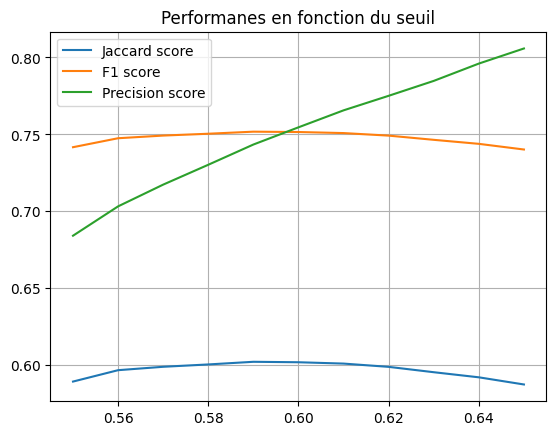

In [44]:
thresholds = [0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65]
plt.plot(thresholds, list_jaccard, label='Jaccard score')
plt.plot(thresholds, list_f1, label='F1 score')
# plt.plot(thresholds, list_hamming, label='Hamming loss')
plt.plot(thresholds, list_precision, label='Precision score')
plt.legend()
plt.title('Performanes en fonction du seuil')
plt.grid(True)
plt.show()

#### Scénario choisi : 
Le modèle prédisant un nombre de tags variable, avec un seuil de probabilité >=0.6

### Modèle final pour l'API : BERT

In [45]:
# model = BERTClass()  # Créer une instance de votre modèle
# checkpoint = torch.load('bert_model.pth', map_location=torch.device('cpu'))
# model.load_state_dict(checkpoint['model_state_dict'])  # Chargez les poids du modèle depuis le fichier
# model = model.to(torch.device('cpu'))
# model.eval()  #

# tokenizer = BertTokenizer.from_pretrained('API/bert_tokenizer', map_location=torch.device('cpu'))

In [49]:
# # Chargement du modèle sur le CPU
# model = BERTClass()
# model.load_state_dict(torch.load('API/bert_model.pth', map_location='cpu'))
# model = model.to(torch.device('cpu'))